# Exercise 1

This notebook provides a predictive model to classify patients who have stroke, using the Kaggle stroke dataset: (https://www.kaggle.com/asaumya/healthcare-dataset-stroke-data). This is an (imbalanced class) binary classification problem. 

We start with some basic inference and exploratory data analysis on the dataset, such as checking the dtype, distributions of the feature variables and how they are correlated with the target ('stroke').



In [78]:
# load packages, see requirements.txt

import sys 
print("Python version: {}". format(sys.version))

import pandas as pd 
print("pandas version: {}". format(pd.__version__))

import matplotlib 
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn
print("seaborn version: {}". format(seaborn.__version__))

import pandas_profiling # Optional: free source package for EDA, https://pypi.org/project/pandas-profiling/
print("pandas_profiling version: {}". format(pandas_profiling.__version__))

import numpy as np 
print("NumPy version: {}". format(np.__version__))

import scipy as sp 
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display # for pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn 
print("scikit-learn version: {}". format(sklearn.__version__))

import xgboost 
print("xgboost version: {}". format(xgboost.__version__))

Python version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas version: 0.24.2
matplotlib version: 2.2.4
seaborn version: 0.9.0
pandas_profiling version: 2.3.0
NumPy version: 1.16.4
SciPy version: 1.3.0
IPython version: 7.6.1
scikit-learn version: 0.20.4
xgboost version: 0.90


In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

import time
import random
import itertools

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Ignore warnings in IPython
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Initialising the random seed 
random.seed(42)

# I) Loading the data and basic inference

In [4]:
# load the csv file and preview the basic information
health_stroke_df = pd.read_csv('train_2v.csv')
health_stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


There are 43400 data points, where only `[bmi, smoking_status]` have missing values. 

In [5]:
# summarising how many entries are missing
total_entries = len(health_stroke_df)
bmi_number_of_missing = health_stroke_df.bmi.isnull().sum()
smoke_number_of_missing = health_stroke_df.smoking_status.isnull().sum()
bmi_missing_percent = 100*bmi_number_of_missing/total_entries
smoke_missing_percent = 100*smoke_number_of_missing/total_entries

# print the missing value info
print(f"Missing entries details:\n")
print(f"bmi has {bmi_number_of_missing} ({bmi_missing_percent}%) missing values.")
print(f"smoking_status has {smoke_number_of_missing} ({smoke_missing_percent}%) missing values")

Missing entries details:

bmi has 1462 (3.3686635944700463%) missing values.
smoking_status has 13292 (30.62672811059908%) missing values


In [6]:
# Inspecting the first 5 rows of the dataset
health_stroke_df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0  30669    Male   3.0             0              0           No   
1  30468    Male  58.0             1              0          Yes   
2  16523  Female   8.0             0              0           No   
3  56543  Female  70.0             0              0          Yes   
4  46136    Male  14.0             0              0           No   

      work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0      children          Rural              95.12  18.0              NaN   
1       Private          Urban              87.96  39.2     never smoked   
2       Private          Urban             110.89  17.6              NaN   
3       Private          Rural              69.04  35.9  formerly smoked   
4  Never_worked          Rural             161.28  19.1              NaN   

   stroke  
0       0  
1       0  
2       0  
3       0  
4       0

$\color{blue}{\text{unique label/value investigation}}$

In [7]:
# check the number of unique values for each features
# and whether each entries is unique 
health_stroke_df.nunique()

id                   43400
gender                   3
age                    104
hypertension             2
heart_disease            2
ever_married             2
work_type                5
Residence_type           2
avg_glucose_level    12543
bmi                    555
smoking_status           3
stroke                   2
dtype: int64

We can see that each entries has an unique id, thus it is safe to say there aren't any duplicate entries and all entries are unique. Moreover, all feature variables except `[age, avg_glucose_level, bmi]` only have a few unique values and therefore might be treated as categorical variables. 

In [8]:
# Inspect the likely categorical variables
likely_cat_col = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in likely_cat_col:
    print(f"{col}:", health_stroke_df[col].unique())

gender: ['Male' 'Female' 'Other']
ever_married: ['No' 'Yes']
work_type: ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
Residence_type: ['Rural' 'Urban']
smoking_status: [nan 'never smoked' 'formerly smoked' 'smokes']


Now let's us verify if `[hypertension, heart_disease, stroke]` are boolean [0,1] variable

In [9]:
# Inspect the likely boolean variables
likely_bool_col = ['hypertension', 'heart_disease', 'stroke']

for col in likely_bool_col:
    print(f"{col}:", health_stroke_df[col].unique())

hypertension: [0 1]
heart_disease: [0 1]
stroke: [0 1]


We therefore conclude that `['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']` can indeed be treated as categorical variables, whereas `['hypertension', 'heart_disease', 'stroke']` as boolean.

In [10]:
# Summary stats for numerical columns, i.e [age, avg_glucose_level, bmi]
numeric_col = ['age', 'avg_glucose_level', 'bmi']
health_stroke_df[numeric_col].describe()

age  avg_glucose_level           bmi
count  43400.000000       43400.000000  41938.000000
mean      42.217894         104.482750     28.605038
std       22.519649          43.111751      7.770020
min        0.080000          55.000000     10.100000
25%       24.000000          77.540000     23.200000
50%       44.000000          91.580000     27.700000
75%       60.000000         112.070000     32.900000
max       82.000000         291.050000     97.600000

Some outliers can be seen in these 3 feature variables. For instance, `age=0.08`, `avg_glucose_level=291.05`.

# Simple checking on aberrant/non-acceptable data inputs 

1) Check if all data in numeric variable columns are non-negative (`['age', 'avg_glucose_level', 'bmi']` do not make sense if they are negative)

In [11]:
print(f"Number of negative value entries")
for num_var in numeric_col:
    non_neg_check = health_stroke_df[num_var].dropna().apply(lambda x: 0 if x>=0 else 1)
    print(f"{num_var}: {non_neg_check.sum()}")

Number of negative value entries
age: 0
avg_glucose_level: 0
bmi: 0


2) For instance, we can check if the patients of `[work_type=children]` are really `children` by checking the ages of the subgroup.

In [12]:
health_stroke_df[health_stroke_df.work_type=='children'].age.max()

16.0

In [13]:
# Figures inline and set visualisation style
%matplotlib inline
sns.set()

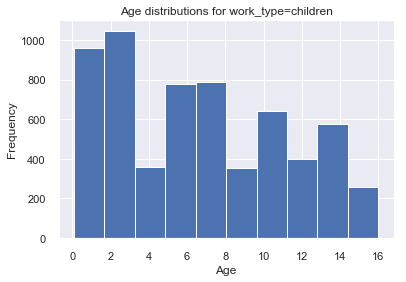

In [14]:
health_stroke_df[health_stroke_df.work_type=='children'].age.plot(kind='hist')
plt.xlabel('Age')
plt.title("Age distribution for work_type=children")
plt.show()

# II) Exploratory Data Analysis (EDA)

In this section, we perform exploratory data analysis on the given healthcare dataset and get some more information about the dataset, so we can then move on to do preprocessing and build an accurate predictive model.



brief inspection on the target variable (i.e. stroke or not)

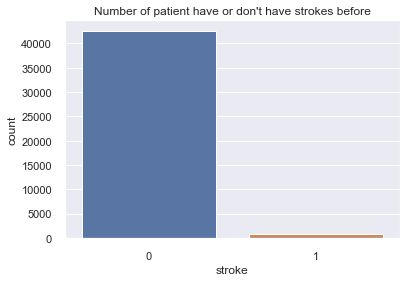

In [15]:
# Bar plot of the number of people have or don't have strokes before 
sns.countplot(x='stroke', data=health_stroke_df)
plt.title("Number of patient have or don't have strokes before")
plt.show()

In [16]:
print('Probability of a patient within the whole dataset having strokes: ')
prob_stroke_whole = health_stroke_df.stroke.mean()
print(prob_stroke_whole)

Probability of a patient within the whole dataset having strokes: 
0.01804147465437788


We can see that we have a very unbalanced class classification problem here, as >97% of the patient in the dataset do not have stroke before. For this reason, we should use confusion matrix as the metric/KPI (key performance indicator) instead of simply the accuracy here.

# EDA on non-numeric feature variables

Simple example 1: how gender might affect the prediction stroke or not

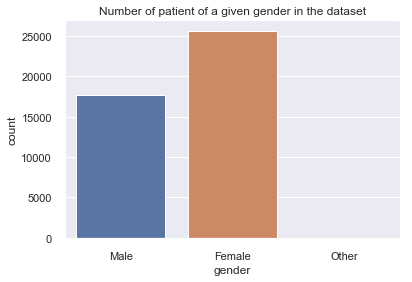

In [17]:
sns.countplot(x='gender', data=health_stroke_df)
plt.title("Number of patient of a given gender in the dataset")
plt.show()

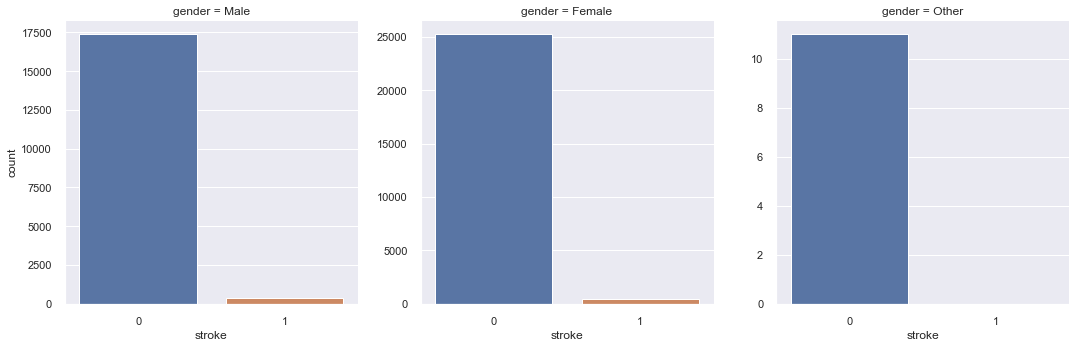

In [18]:
sns.factorplot(x='stroke', col='gender', kind='count', data=health_stroke_df, sharey=False)
plt.show()

In [19]:
# Brief examining how gender might affect a patient likely to have strokes before or not
for sex in health_stroke_df.gender.unique():
    print(f"Probability of Gender={sex} having strokes before: ")
    print(health_stroke_df[health_stroke_df.gender==sex].stroke.mean())

Probability of Gender=Male having strokes before: 
0.019860076732114647
Probability of Gender=Female having strokes before: 
0.016793298266121175
Probability of Gender=Other having strokes before: 
0.0


Compared with the case of considering all gender, where the probability of a patient within the dataset having strokes before = 0.018, we can see the `gender` feature alone is not very conclusive in predicting whether a patient is likely to have strokes before or not as the probabilities of cases grouped by gender are very much similar, except in the case `Gender=Other` (however the sample size is too small in that case).

Similarly, example 2: how `[hypertension, heart_disease]` might affect how likely a patient have strokes before

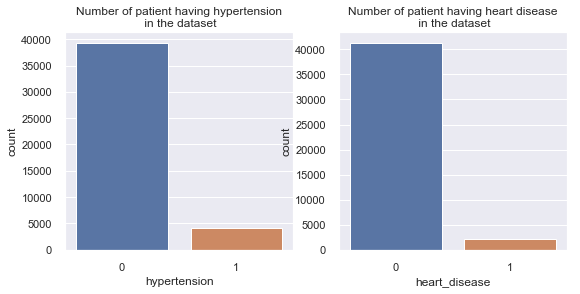

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize =(9,4) )
sns.countplot(x='hypertension', data=health_stroke_df, ax=ax1)
sns.countplot(x='heart_disease', data=health_stroke_df, ax=ax2)
ax1.set_title("Number of patient having hypertension\n in the dataset")
ax2.set_title("Number of patient having heart disease\n in the dataset")
plt.show()

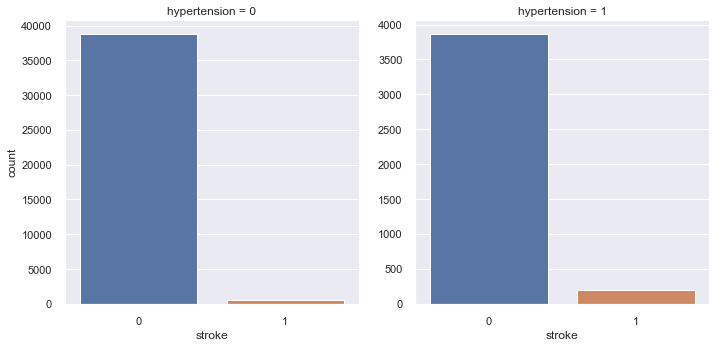

In [21]:
sns.factorplot(x='stroke', col='hypertension', kind='count', data=health_stroke_df, sharey=False)
plt.show()

In [22]:
# Brief examining how hypertension might affect a patient likely to have strokes before or not
for high_blood_pressure in health_stroke_df.hypertension.unique():
    print(f"Probability of hypertension={high_blood_pressure} having strokes before: ")
    print(health_stroke_df[health_stroke_df.hypertension==high_blood_pressure].stroke.mean())

Probability of hypertension=0 having strokes before: 
0.01481989882813493
Probability of hypertension=1 having strokes before: 
0.04924895345973898


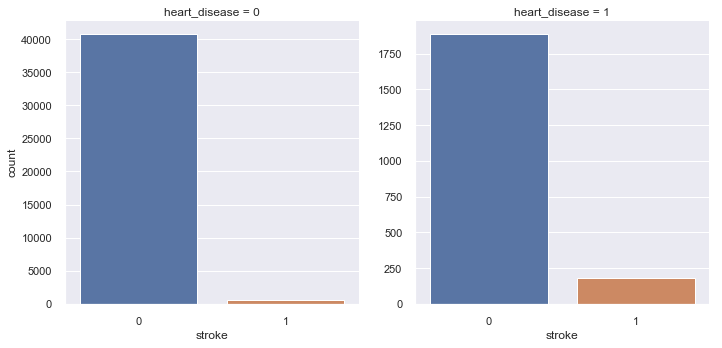

In [23]:
sns.factorplot(x='stroke', col='heart_disease', kind='count', data=health_stroke_df, sharey=False)
plt.show()

In [24]:
# Brief examining how heart_disease might affect a patient likely to have strokes before or not
for heart in health_stroke_df.heart_disease.unique():
    print(f"Probability of heart disease={heart} having strokes before: ")
    print(health_stroke_df[health_stroke_df.heart_disease==heart].stroke.mean())

Probability of heart disease=0 having strokes before: 
0.01465963520247714
Probability of heart disease=1 having strokes before: 
0.08583899127061105


Compared with the case of considering the whole dataset, where the probability of a patient having strokes before = 0.018, we can see the probabilities of having stroke for patients having hypertension or heart_disease before alone are significantly different. This suggests `[hypertension, heart_disease]` might be very useful in predicting whether a patient have stroke or not. 

Now perform similar EDA on the other categorical variables

In [25]:
# EDA on categorical variables [hypertension, heart_disease, ever_married, 
# work_type, Residence_type, smoking_status]

def get_prob_per_class_within_one_cat_feat(feature_col, df):
    """
    Function that returns the probabilities of entries of a certain class in one 
    particular feature variable having the target=1 in the dataset df (i.e. a patient 
    having strokes before in this case)

    Parameters
    ----------
    feature_col: str
        The particular feature variable of interest.
    
    df : Dataframe
        The input dataframe containing the dataset.

    Returns
    -------
    prob_per_cat_class_df: Dataframe
        A dataframe with the probabilities of entries of a certain class in one 
    particular feature variable having the target=1


    """
    prob_per_cat_class_df = pd.DataFrame(columns=[feature_col, 'sample_size', 'prob of target=1'])
    class_label_list = []
    prob_list = []
    sample_size_list = []
    for class_label in df[feature_col].dropna().unique():
        stroke_tot = df[df[feature_col]==class_label].stroke.sum()
        tot_count = df[df[feature_col]==class_label].stroke.count()
        sample_size_list.append(tot_count)
        class_label_list.append(class_label)
        prob_list.append(stroke_tot/tot_count)
    prob_per_cat_class_df[feature_col] = class_label_list
    prob_per_cat_class_df['prob of target=1'] = prob_list
    prob_per_cat_class_df['sample_size'] = sample_size_list
    return prob_per_cat_class_df

In [26]:
cat_col = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
prob_df = {}
for cat_var in cat_col:
    print(f"Categorical variable: {cat_var}")
    prob_df[cat_var] = get_prob_per_class_within_one_cat_feat(cat_var, health_stroke_df)
    print(prob_df[cat_var])
    print("-"*30, "\n")

Categorical variable: gender
   gender  sample_size  prob of target=1
0    Male        17724          0.019860
1  Female        25665          0.016793
2   Other           11          0.000000
------------------------------ 

Categorical variable: hypertension
   hypertension  sample_size  prob of target=1
0             0        39339          0.014820
1             1         4061          0.049249
------------------------------ 

Categorical variable: heart_disease
   heart_disease  sample_size  prob of target=1
0              0        41338          0.014660
1              1         2062          0.085839
------------------------------ 

Categorical variable: ever_married
  ever_married  sample_size  prob of target=1
0           No        15462          0.005174
1          Yes        27938          0.025163
------------------------------ 

Categorical variable: work_type
       work_type  sample_size  prob of target=1
0       children         6156          0.000325
1        Private  

In [27]:
# defining a function that returns all the related probability bar plots of patient of a certain class in each 
# particular catorgical feature variable having strokes  

def plot_prob_per_cat_class(df, health_stroke_df, fig_hsize=30, fig_wsize=30, ncols=3, nrows=3, fontsize=20):
    """
    Function that returns bar plots of the probabilities of entries of a certain class in one 
    particular feature variable having the target=1 in the dataset df (i.e. a patient 
    having strokes before in this case)

    Parameters
    ----------    
    df : Dataframe
        The input dataframe containing the probability of target=1 per category class 
        information.

    Returns
    -------
    probability plots per categorical classes

    """
    # initialising the figure plots
    i = 1
    fig = plt.figure(figsize =(fig_hsize, fig_wsize))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    for cat_var in df.keys():
        ax = fig.add_subplot(nrows, ncols, i)
        df[cat_var][['prob of target=1']].plot(kind='bar', ax=ax, fontsize=fontsize)
        plt.hlines(health_stroke_df.stroke.mean(),-1, len(df[cat_var])+.5)
        plt.annotate('prob of target=1 \n for whole dataset', xy=(0.25, 0.018), xytext=(0.05, 0.01), 
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=fontsize)
        ax.set_ylabel('Probability',fontsize=fontsize)
        ax.set_xlabel(cat_var,fontsize=fontsize)
        plt.xticks(np.arange(len(df[cat_var][cat_var])), df[cat_var][cat_var])
        i+=1
    return fig

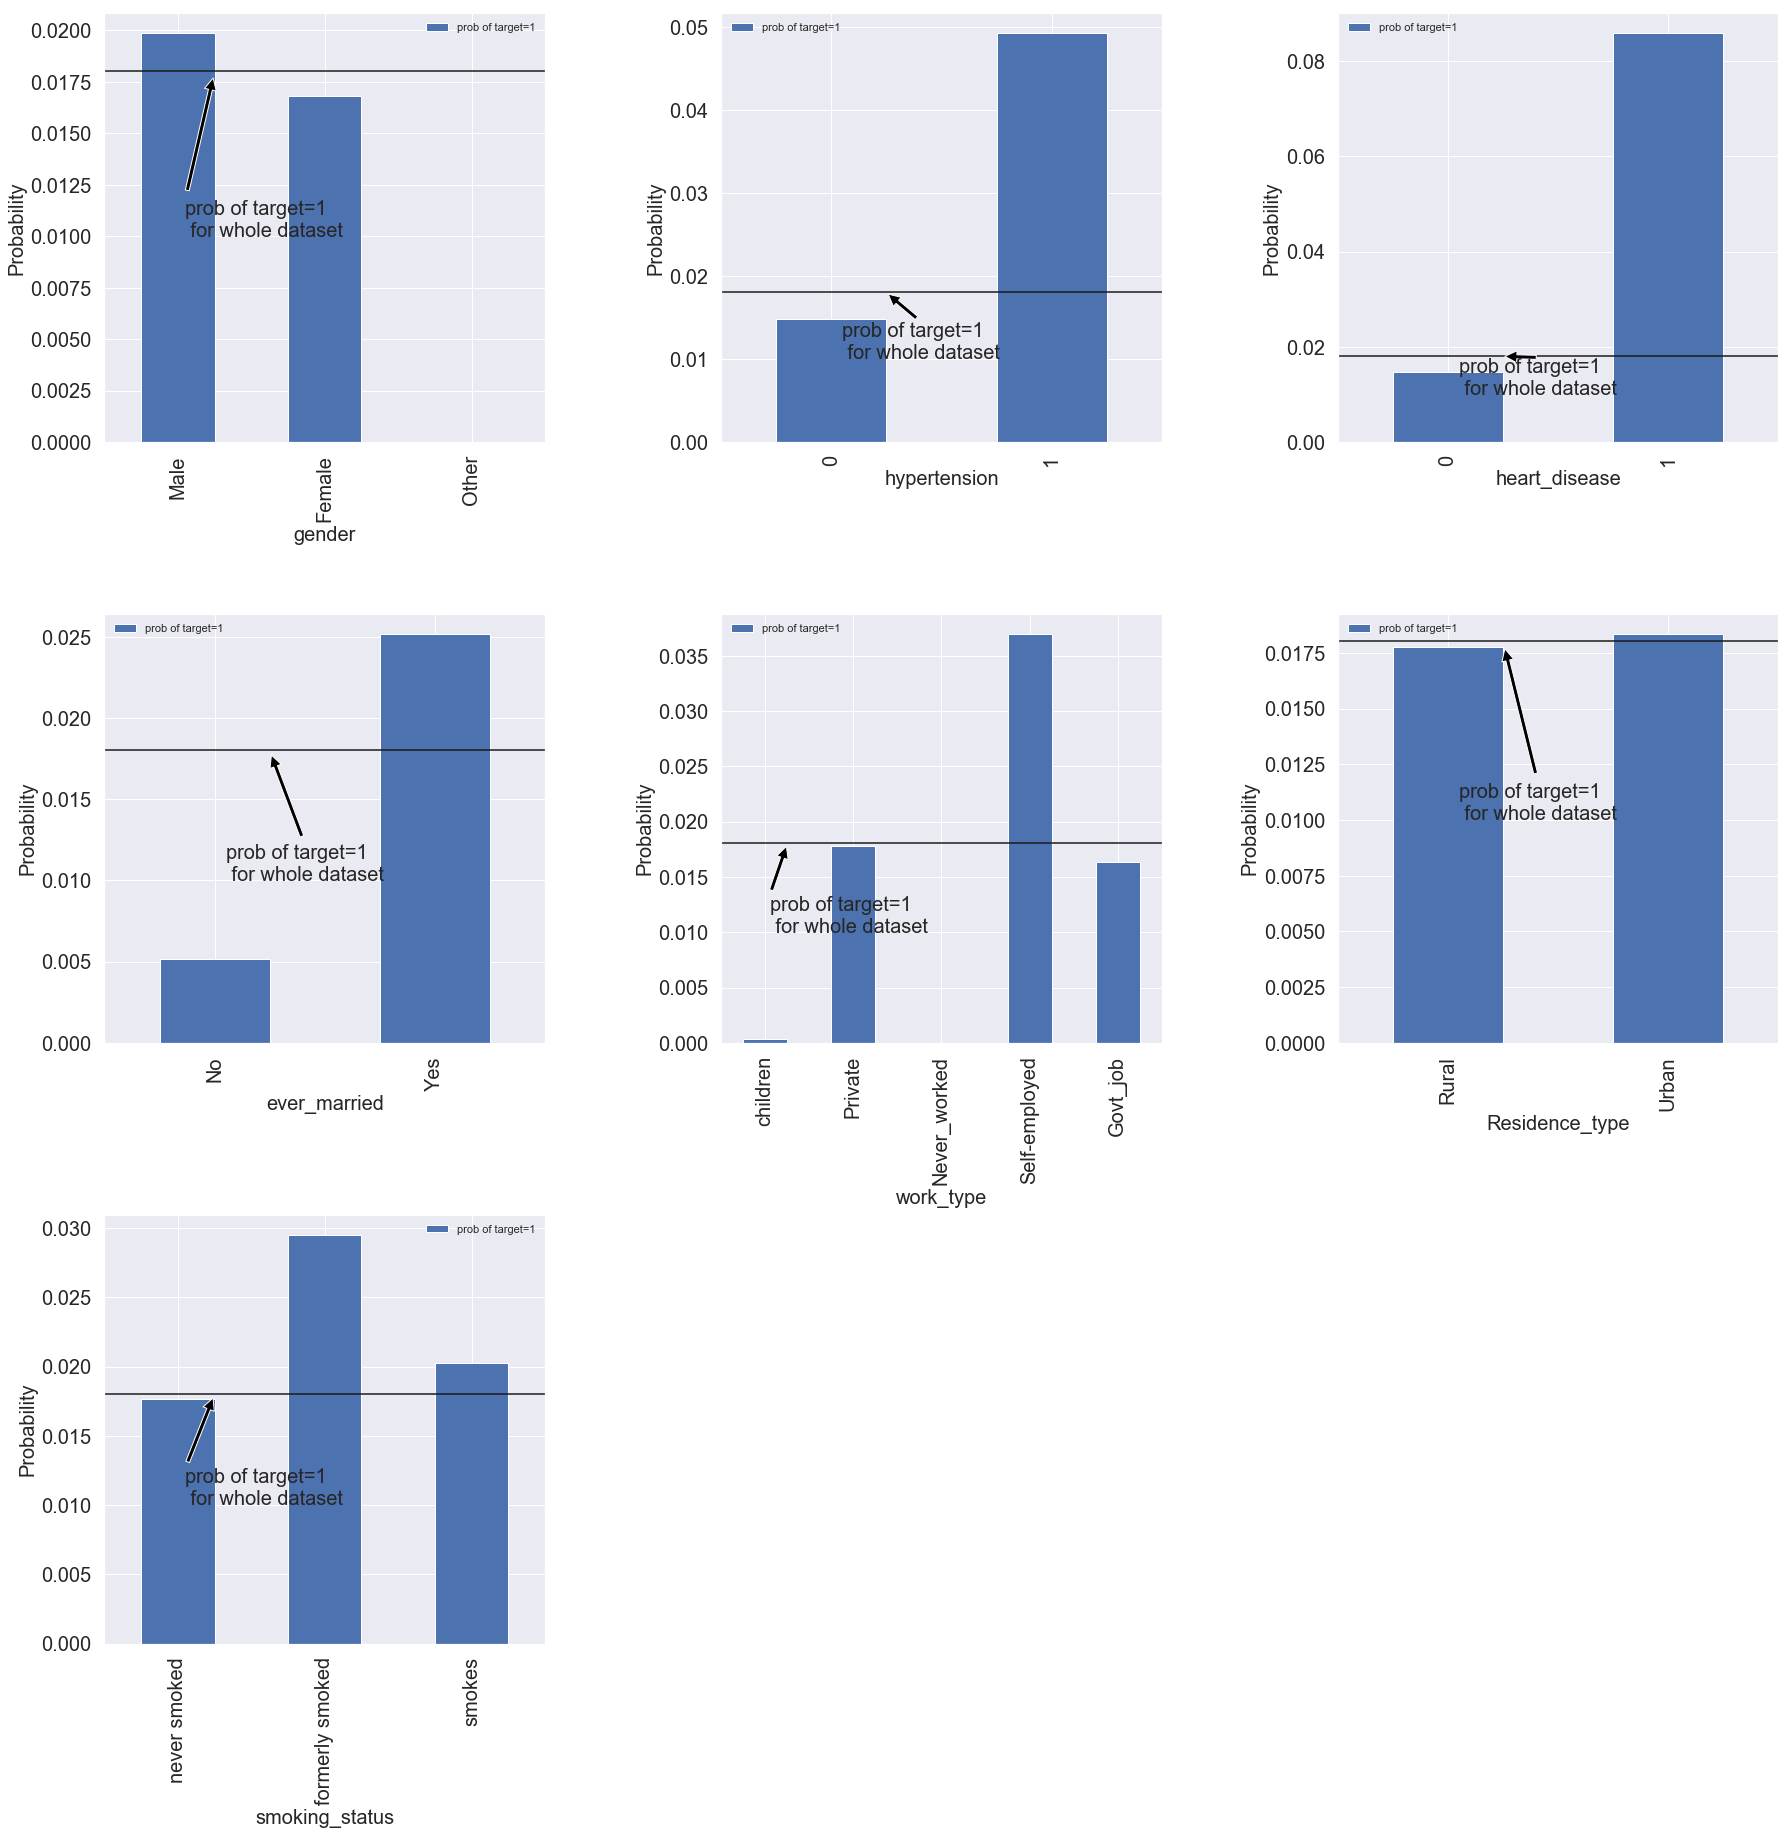

In [28]:
figure_EDA = plot_prob_per_cat_class(prob_df, health_stroke_df, nrows = np.ceil(len(prob_df)/3))

Summary:

Overall, we can see features `[gender, Residence_type]` individually aren't particularly helpful in predicting whether the patient having strokes or not, as the probabilities per categorical class within these features are very much similar to that of the whole dataset (i.e. prob=0.018).

For features `[hypertension, heart_disease]`, the probabilities of having strokes for patients having these health issues are significantly different and much higher than that of the whole dataset (i.e. prob=0.018). This suggests both would be very important features in determining whether the patient having stroke or not.

For features `[ever_married, work_type, smoking_status]`, the probabilities of having strokes for patients of certain classes are considerably different to that of the whole dataset (i.e. prob=0.018). This suggests these remaining features would be helpful in determining whether the patient having stroke or not.

# EDA on numeric variables `[age, avg_glucose_level, bmi]`:

In [33]:
def plot_num_var_KDE(df, num_var):
    """
    Function that returns kernel density estimate (KDE) plot of the given numeric variable
    for each binary target groups in the dataset df (i.e. a patient 
    having strokes before in this case)

    Parameters
    ----------    
    df : Dataframe
        The input dataframe containing the (healthcare) dataset
        
    num_var : str
        The numeric variable to be plotted

    Returns
    -------
    kernel density estimate (KDE) plot of num_var per target class

    """
    facet_plot = sns.FacetGrid(df, hue='stroke', aspect=4)
    facet_plot.map(sns.kdeplot, num_var, shade=True)
    facet_plot.set(xlim=(0, df[num_var].max()))
    facet_plot.add_legend()
    plt.title(f'KDE plot of {num_var} per strokes class labels')
    return facet_plot


def plot_num_var_vio_strip(df, num_var):
    """
    Function that returns violin and strip plots of the given numeric variable
    for each binary target groups in the dataset df (i.e. a patient 
    having strokes before in this case)

    Parameters
    ----------    
    df : Dataframe
        The input dataframe containing the (healthcare) dataset
        
    num_var : str
        The numeric variable to be plotted

    """
    fig, ax =  plt.subplots(ncols=2, sharey=True, figsize =(12,5))
    sns.violinplot(x='stroke', y=num_var, data=df, ax=ax[0])
    ax[0].set_title(f'Distribution of {num_var} per strokes class labels\n (violin plot)')
    sns.stripplot(x='stroke', y=num_var, data=df, alpha=0.2, jitter=True, ax=ax[1])
    ax[1].legend(('no stroke','stroke'))
    ax[1].set_title(f'Distribution of {num_var} per strokes class labels\n (strip plot)')

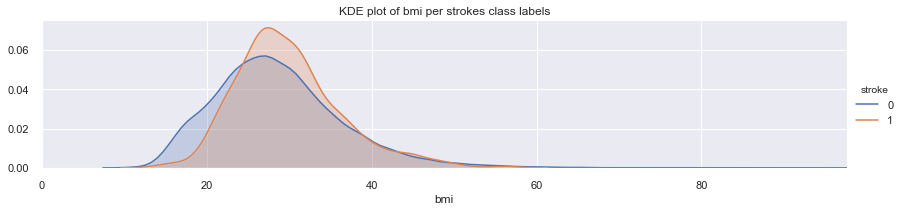

In [30]:
plot_num_var_KDE(health_stroke_df, 'bmi')

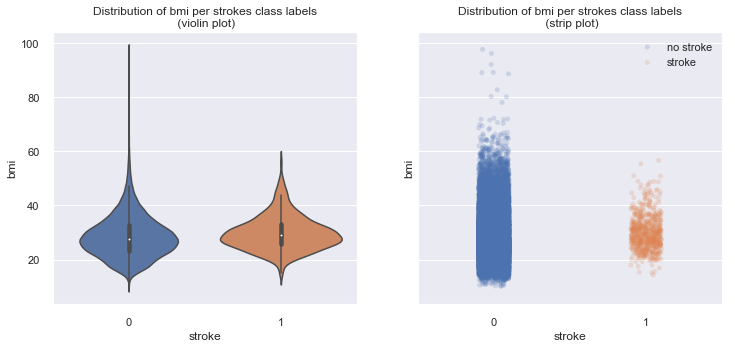

In [34]:
plot_num_var_vio_strip(health_stroke_df, 'bmi')

In [35]:
health_stroke_df.groupby('stroke').bmi.describe()

count       mean       std   min   25%   50%   75%   max
stroke                                                            
0       41295.0  28.585371  7.788594  10.1  23.2  27.7  32.8  97.6
1         643.0  29.868118  6.344873  14.3  25.7  29.1  33.0  56.6

From the plots and summary stats, the distributions of bmi for patients having stroke or not look roughly similar, both seem resemble a normal distribution with mean around `[27-30]`, except the spread or standard deviation of that of having stroke is smaller (this might however due to the fact that the sample size is much smaller).

It is not very conclusive whether the feature `[bmi]` is predictive or not. One might need to perform some hypothesis tests (using p-value) to investigate further.

# Aside: a simple example of bootstrapping and hypothesis testing

In [36]:
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """ 
    Function that draw bootstrap replicates.

    Parameters
    ----------    
    data : arr-like 
        The input data to be investigated and bootstrapped.
        
    func : func
        Function on the bootstrap samples to return

    Returns
    -------
    bs_replicates : 
        bootstrap replicates

    """

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

In [37]:
# Compute the mean of bmi
mean_bmi = np.mean(health_stroke_df.bmi)
bmi_stroke = health_stroke_df.groupby('stroke').get_group(1).bmi
bmi_no_stroke = health_stroke_df.groupby('stroke').get_group(0).bmi
empirical_diff_means = np.array([np.mean(bmi_stroke) - np.mean(bmi_no_stroke)]*4000)

# Generate shifted arrays
bmi_stroke_shifted = bmi_stroke - np.mean(bmi_stroke) + mean_bmi
bmi_no_stroke_shifted = bmi_no_stroke - np.mean(bmi_no_stroke) + mean_bmi

# Compute 4,000 bootstrap replicates from shifted arrays
bs_replicates_stroke = draw_bs_reps(bmi_stroke_shifted, np.mean, 4000)
bs_replicates_no_stroke = draw_bs_reps(bmi_no_stroke_shifted, np.mean, 4000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_stroke - bs_replicates_no_stroke

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means)/len(bs_replicates)
print('p-value =', p)

p-value = 0.0


This hypothesis testing suggests it is extremely unlikely (`p-value = 0.0`) that patients having stroke and that do not would have the same mean bmi given the healthcare dataset.

2) Age

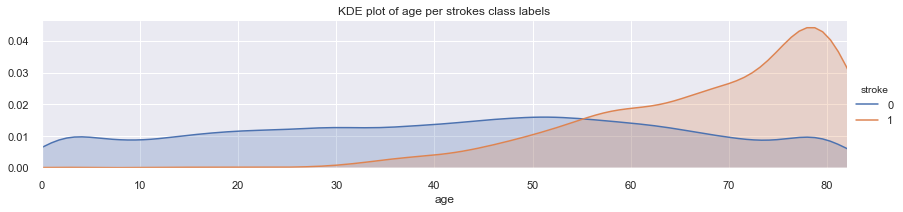

In [38]:
plot_num_var_KDE(health_stroke_df, 'age')

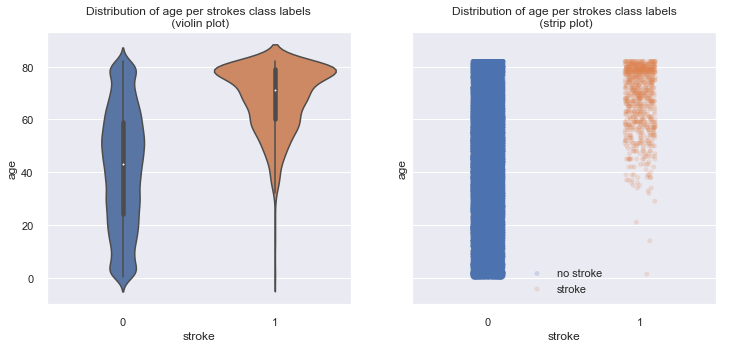

In [39]:
plot_num_var_vio_strip(health_stroke_df, 'age')

In [40]:
health_stroke_df.groupby('stroke').age.describe()

count       mean        std   min   25%   50%   75%   max
stroke                                                             
0       42617.0  41.741565  22.385094  0.08  24.0  43.0  59.0  82.0
1         783.0  68.143448  12.316537  1.32  60.0  71.0  79.0  82.0

From the plots and summary stats, we can easily see the distributions look very different for patients having stroke or not, with the ages of patients not having stroke distributed quite uniformly across the whole range `[0-82]`, whereas that having stroke are significantly skewed towards the high age end. 

This suggests the feature `[age]` is very predictive on modelling whether patients having stroke or not.

3) average glucose level

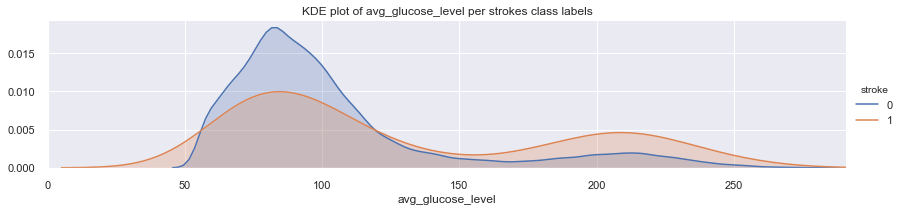

In [41]:
plot_num_var_KDE(health_stroke_df, 'avg_glucose_level')

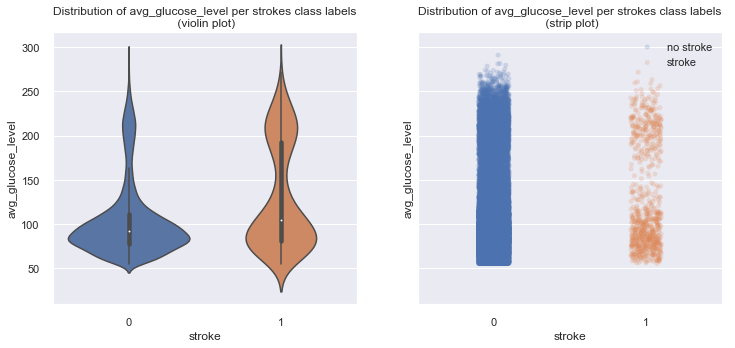

In [42]:
plot_num_var_vio_strip(health_stroke_df, 'avg_glucose_level')

In [43]:
health_stroke_df.groupby('stroke').avg_glucose_level.describe()

count        mean        std    min    25%     50%     75%     max
stroke                                                                      
0       42617.0  104.021590  42.608788  55.00  77.50   91.47  111.67  291.05
1         783.0  129.582669  59.734073  55.01  80.99  104.47  192.36  271.74

From the plots and summary stats, the distributions of average glucose level for patients having stroke or not look relatively similar, both resemble a double-peaked distribution with peaks around `[80-100]` and `[190-220]`, with regions around the higher peaks less populated. The higher peak of the distribution of having stroke, however, seem to be significantly higher compared to that not having stroke. This is also illustrated by the `0.75` percentiles of the distributions. One might want to perform some hypothesis tests (using p-value) to investigate further.

This suggests the feature `[avg_glucose_level]` could be predictive. 

We can also bin the numeric variables into different groups, see how the probabilities of having strokes vary in different groups and compare them with that of the whole dataset, see below.

In [44]:
# Bin the numeric variables into groups
age_bins = [0,10,20,30,40,50,60,70,80,90]
health_stroke_df['age_group'] = pd.cut(health_stroke_df.age, age_bins)
bmi_bins = [10,20,30,40,50,60,100]
health_stroke_df['bmi_group'] = pd.cut(health_stroke_df.bmi, bmi_bins)
avg_glucose_bins = [50,90,130,170,210,250,300]
health_stroke_df['avg_glucose_group'] = pd.cut(health_stroke_df.avg_glucose_level, avg_glucose_bins)

# inspecting the results
health_stroke_df.iloc[:,-3:].head()

age_group bmi_group avg_glucose_group
0   (0, 10]  (10, 20]         (90, 130]
1  (50, 60]  (30, 40]          (50, 90]
2   (0, 10]  (10, 20]         (90, 130]
3  (60, 70]  (30, 40]          (50, 90]
4  (10, 20]  (10, 20]        (130, 170]

In [45]:
# Calculating the probability of having stroke per each bin within one particular numeric column
num_bin_col = ['age_group', 'bmi_group', 'avg_glucose_group']
prob_num_df = {}
for num_bin_var in num_bin_col:
    print(f"Numerical variable: {num_bin_var.split('_group')[0]}")
    prob_num_df[num_bin_var] = get_prob_per_class_within_one_cat_feat(num_bin_var, health_stroke_df)
    print(prob_num_df[num_bin_var])
    print("-"*30, "\n")

Numerical variable: age
  age_group  sample_size  prob of target=1
0   (0, 10]         4598          0.000217
1  (50, 60]         6691          0.019280
2  (60, 70]         5229          0.033276
3  (10, 20]         4417          0.000226
4  (40, 50]         6441          0.007763
5  (70, 80]         4393          0.074209
6  (30, 40]         5521          0.003804
7  (20, 30]         5221          0.000383
8  (80, 90]          889          0.088864
------------------------------ 

Numerical variable: bmi
   bmi_group  sample_size  prob of target=1
0   (10, 20]         5057          0.002966
1   (30, 40]        12530          0.018595
2   (50, 60]          487          0.008214
3   (20, 30]        21099          0.016494
4   (40, 50]         2676          0.016069
5  (60, 100]           89          0.000000
------------------------------ 

Numerical variable: avg_glucose
  avg_glucose_group  sample_size  prob of target=1
0         (90, 130]        15670          0.012827
1          (50

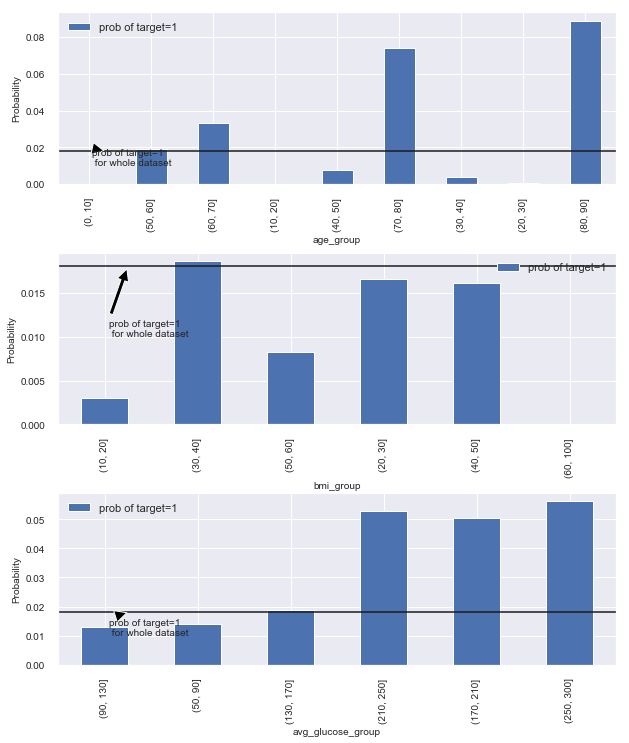

In [46]:
figure_EDA_num_var = plot_prob_per_cat_class(prob_num_df, health_stroke_df, 10,12, ncols=1, nrows=3, fontsize=10)

Summary:

By binning the numeric variables into groups, we can now clearly see how certain ranges of numeric values would have an impact on the probability of having strokes.

For the `[age]` group, we can see for younger patients, especially in the range `[0-30]`, the probabilities of having strokes having strokes are significantly lower `<0.01`, whereas there is significant increase in probability for patients with age above `[60+]`.

For the `[bmi]` group, we can see for patients with `[bmi]` in the intermediate range `[20-50]`, the probabilities of having strokes are very much similar to that of the entire dataset, whereas there is significant decrease in probability for patients with other bmi ranges (Caution: this might be small sample sizes in these groups).

For the `[avg_glucose_level]` group, we can see for patients with `[avg_glucose_level]` in the lower range `[<170]`, the probabilities of having strokes are very much similar to that of the entire dataset, whereas there is significant increase in probability for patients with higher `[avg_glucose_level]` (Caution: this might be small sample sizes in these groups).

# Correlation study

We now study how the feature variables are correlated with the targe ('stroke') in this dataset.

In [47]:
health_stroke_cat_numeric_df = health_stroke_df.iloc[:,:-3].copy()
health_stroke_cat_numeric_df.drop(columns=['id'], inplace=True)

# convert the categorical variables to categorical type
# (for efficient reason)
cat_col = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
health_stroke_cat_numeric_df[cat_col] = health_stroke_cat_numeric_df[cat_col].astype('category')
health_stroke_cat_numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
gender               43400 non-null category
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null category
work_type            43400 non-null category
Residence_type       43400 non-null category
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null category
stroke               43400 non-null int64
dtypes: category(5), float64(3), int64(3)
memory usage: 2.2 MB


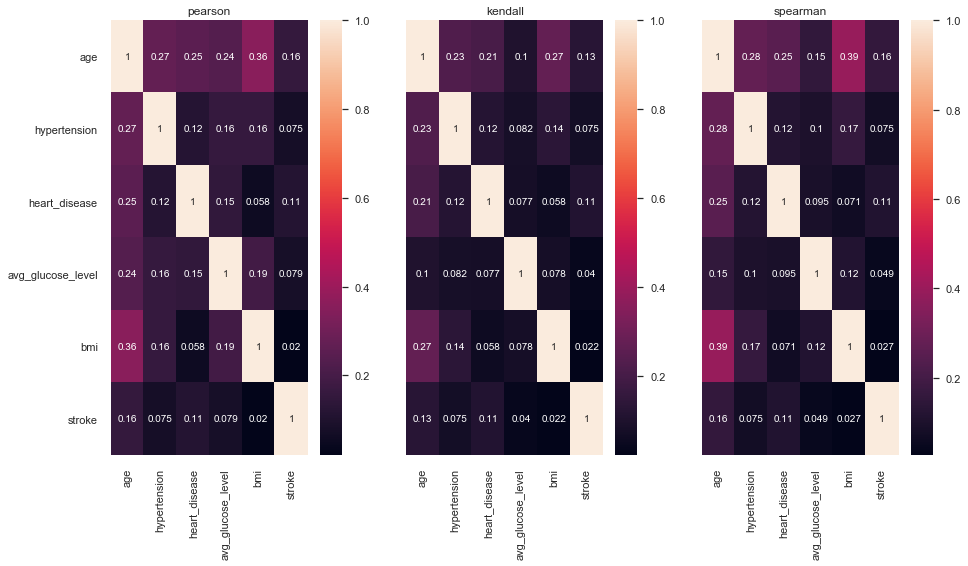

In [48]:
corr_type = ['pearson', 'kendall', 'spearman']
fig, ax = plt.subplots(ncols=3, sharey=True, figsize =(15,8) )
i=0

# correlation heatmap for numeric variables only
for corr in corr_type:
    df_corr = health_stroke_cat_numeric_df.corr(method=corr)
    sns.heatmap(df_corr, annot=True, annot_kws={"size": 10},ax=ax[i])
    ax[i].set_title(corr)
    i+=1

From the heatmap, we can see the features `[age, heart_disease]` are the two most correlated numeric variables with the target ('stroke'), whereas `[hypertension, avg_glucose_level]` are next and `[bmi]` has the least correlation. This is true for all three correlation coefficients tested.

Ranked by correlation coefficient, we have `[age > heart_disease > hypertension > avg_glucose_level > bmi]` (for pearson's r)

# - correlation, categorical variable

Next we compute the correlation coefficients for categorical variables. To do so, we would need to perform the label encoding preprocessing step, i.e. converting categorical variables into numeric form (using LabelEncoder/custom mapping for ordinal; OneHotEncoder/pd.get_dummies for nominal).

This preprocessing step is also necessary for training certain ML models.

In [49]:
# Creating a copy of the health stroke dataframe and imputing the missing values
# in ['bmi', 'smoking_status'] for calculating the correlation coefficient
# (Imputation methods will be explained in more detail in the next section)
health_stroke_df2 = health_stroke_df.iloc[:,:-3].copy()

# using median for impute bmi missing
health_stroke_df2.bmi.fillna(health_stroke_df2.bmi.median(), inplace=True)
# using a new label 'no_info' for impute smoking_status missing
health_stroke_df2.smoking_status.fillna('no info', inplace=True)

In [50]:
# Label encoding

nom_col = ['gender', 'ever_married', 'work_type', 'Residence_type']
ord_col = ['smoking_status']

health_stroke_df2 = pd.get_dummies(health_stroke_df2, columns = nom_col)

ord_var_code = 'smoking_status_code'
smoke_mapper = {'never smoked': 0, 'no info': 1,
                'formerly smoked': 2,'smokes':3}
health_stroke_df2[ord_var_code] = health_stroke_df2['smoking_status'].map(smoke_mapper)

Correlation heatmap between the (categorical) features and target ('stroke') variables

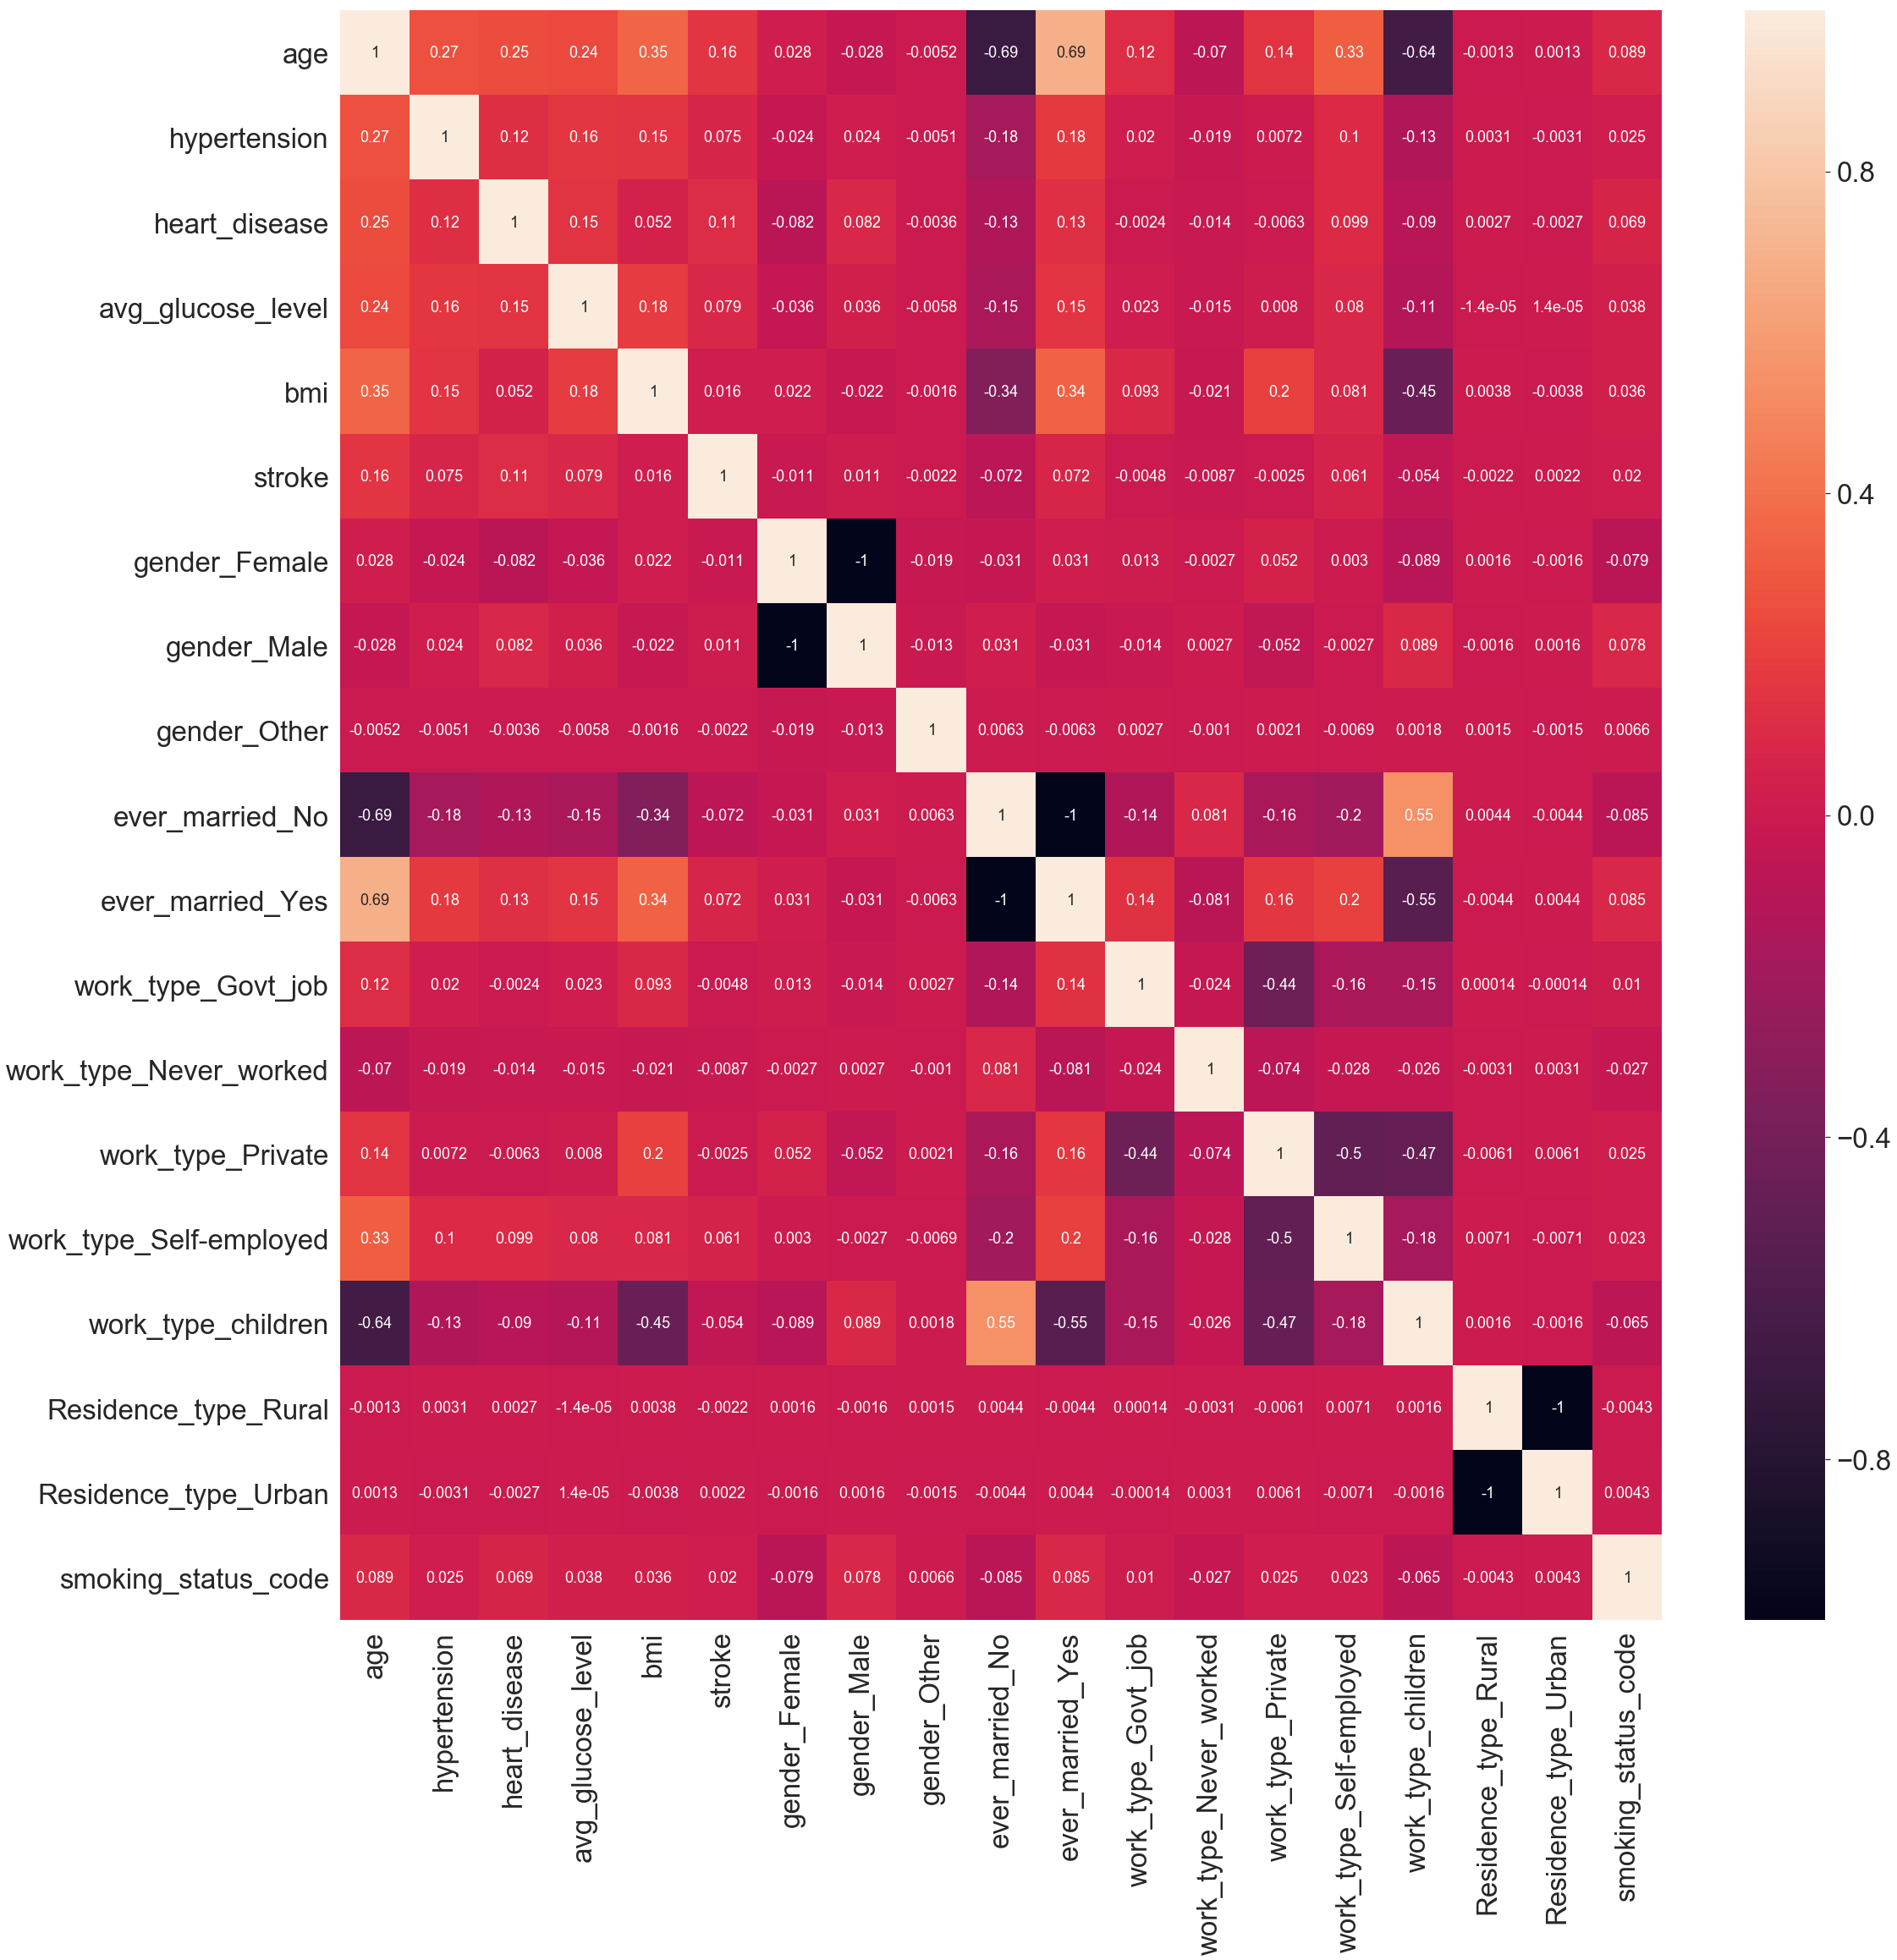

In [51]:
pearson_corr_full = health_stroke_df2.drop(columns=['id']).corr()

sns.set(font_scale=3)

fig = plt.figure(figsize =(35,35))
sns.heatmap(pearson_corr_full, annot=True, annot_kws={"size": 18})
plt.show()

From this second heatmap, we can see the categorical features `[gender, Residence_type]` have very low correlation coefficients with the target ('stroke') i.e. `abs<0.012`, confirming pervious observations using the corresponding barplots. 

`ever_married` and various classes (i.e. `children, Self-employed`) within categorical features `[work_type]` have relatively high correlation coefficients with the target ('stroke') i.e.  `abs>0.05`, again confirming pervious observations using the corresponding barplots. 

Again, surprisingly, `smoking_status` do not seem to have a significant correlation (i.e. `~0.02`) with patients having strokes or not. 

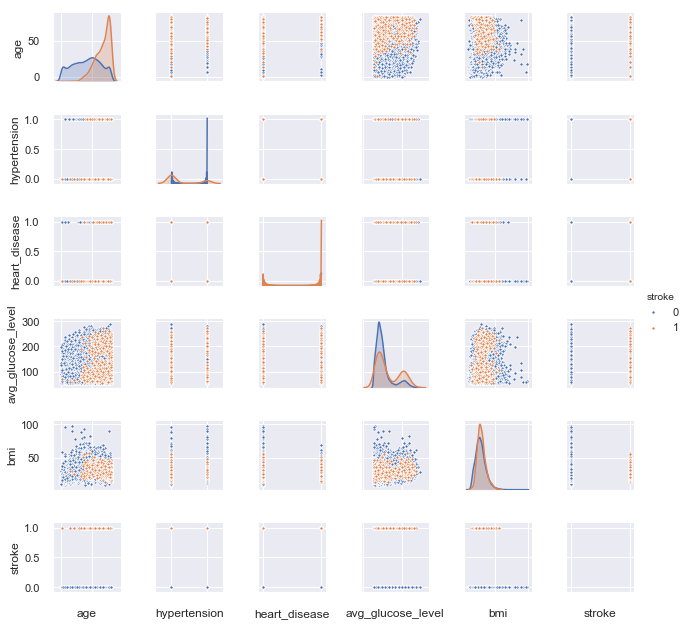

In [52]:
%matplotlib inline
sns.set()

# pair plots of entire dataset (for reference only)
pair_plot = sns.pairplot(health_stroke_df.iloc[:,1:-3], hue='stroke', palette='deep', size=1.5,
                         diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
pair_plot.set(xticklabels=[])

# (For reference:) Pandas Profiling

Similar EDA results can be performed using the free source pandas-profiling package, see results below:

In [53]:
health_stroke_df.iloc[:,:-3].profile_report(style={'full_width':True})

# III) Preprocessing

$\color{blue}{\text{1) Dealing with missing values}}$

option (A): dropping missing values

In [54]:
health_stroke_without_NAN_df = health_stroke_df.iloc[:,:-3].copy().dropna()
# preview the resulting df basic info 
health_stroke_without_NAN_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29072 entries, 1 to 43399
Data columns (total 12 columns):
id                   29072 non-null int64
gender               29072 non-null object
age                  29072 non-null float64
hypertension         29072 non-null int64
heart_disease        29072 non-null int64
ever_married         29072 non-null object
work_type            29072 non-null object
Residence_type       29072 non-null object
avg_glucose_level    29072 non-null float64
bmi                  29072 non-null float64
smoking_status       29072 non-null object
stroke               29072 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 2.9+ MB


option (B): (simple) Imputation for missing values in the [bmi, smoking_status] columns:
- bmi: using median
- smoking_status: using mode

Here we use the median for imputing the missing values in `bmi` as there are some outliers within the variable which might obscure the mean values. For `smoking_status`, we use a new label `no info`. 

One might also imputing using the mode instead. We will briefly investigate whether it is alright to impute missing values in `smoking_status` using mode in the following.

Smoking status per work_type class

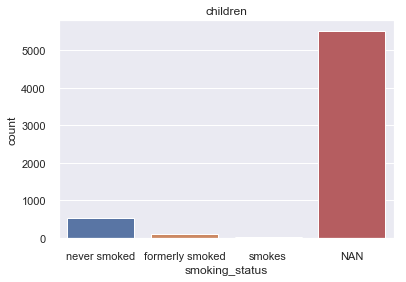

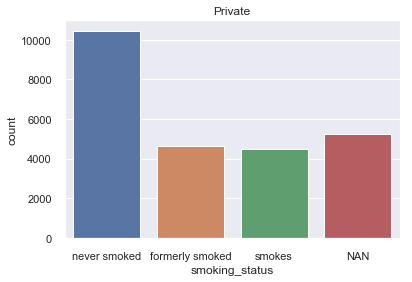

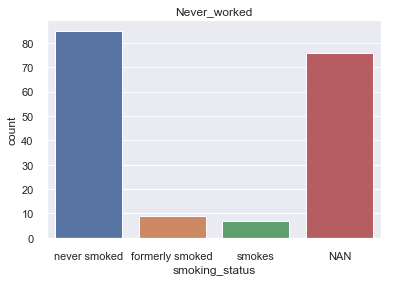

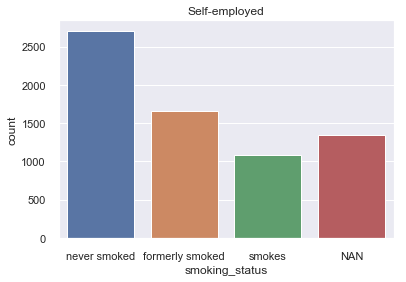

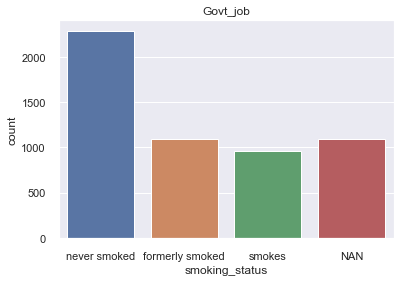

In [55]:
health_stroke_df_temp = health_stroke_df.copy()
health_stroke_df_temp.smoking_status.fillna('NAN', inplace=True)

for work in health_stroke_df_temp.work_type.unique(): 
    sns.countplot(x='smoking_status', data=health_stroke_df_temp.groupby('work_type').get_group(work), 
                  order=['never smoked', 'formerly smoked', 'smokes', 'NAN'])
    plt.title(work)
    plt.show()

Smoking status per gender class

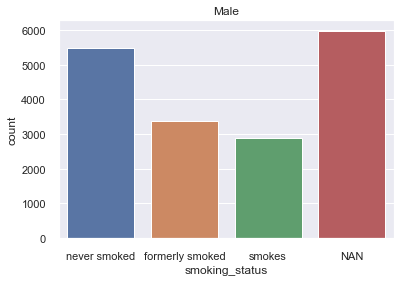

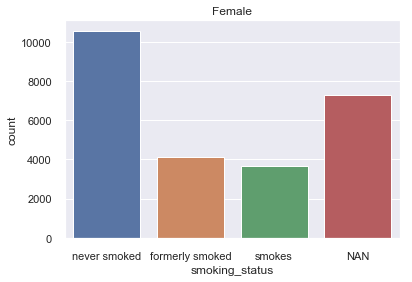

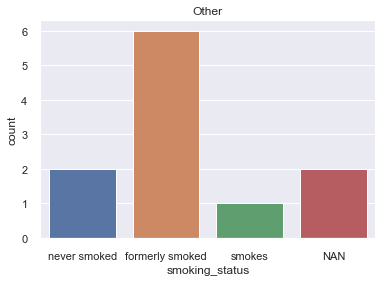

In [56]:
for work in health_stroke_df_temp.gender.unique(): 
    sns.countplot(x='smoking_status', data=health_stroke_df_temp.groupby('gender').get_group(work),
                  order=['never smoked', 'formerly smoked', 'smokes', 'NAN'])
    plt.title(work)
    plt.show()

As examples, we have briefly checked how the smoking status are distributed for various `gender` or `work_type` classes. We can see in all these cases but `gender=Other`, `smoking_status=never smoked` always outnumbers other statuses. However the sample size for `gender=Other` is too small for comparison here.

$\color{blue}{\text{2) Label encoding: converting categorical variables into numeric form for machine learning models}}$

This id already done when computing the correlation coefficients above, imputation strategy=option (B). Please check the `Correlation study` section.

In [57]:
# Preview again the encoded df
health_stroke_df2.head()

id   age  hypertension  heart_disease  avg_glucose_level   bmi  \
0  30669   3.0             0              0              95.12  18.0   
1  30468  58.0             1              0              87.96  39.2   
2  16523   8.0             0              0             110.89  17.6   
3  56543  70.0             0              0              69.04  35.9   
4  46136  14.0             0              0             161.28  19.1   

    smoking_status  stroke  gender_Female  gender_Male  ...  ever_married_No  \
0          no info       0              0            1  ...                1   
1     never smoked       0              0            1  ...                0   
2          no info       0              1            0  ...                1   
3  formerly smoked       0              1            0  ...                0   
4          no info       0              0            1  ...                1   

   ever_married_Yes  work_type_Govt_job  work_type_Never_worked  \
0                 0                   0                       0   
1                 1                   0                       0   
2                 0                   0                       0   
3                 1                   0                       0   
4                 0                   0                       1   

   work_type_Private  work_type_Self-employed  work_type_children  \
0                  0                        0                   1   
1                  1                        0                   0   
2                  1                        0                   0   
3                  1                        0                   0   
4                  0                        0                   0   

   Residence_type_Rural  Residence_type_Urban  smoking_status_code  
0                     1                     0                    1  
1                     0                     1                    0  
2                     0                     1                    1  
3                     1                     0                    2  
4                     1                     0                    1  

[5 rows x 21 columns]

In [58]:
health_stroke_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 21 columns):
id                         43400 non-null int64
age                        43400 non-null float64
hypertension               43400 non-null int64
heart_disease              43400 non-null int64
avg_glucose_level          43400 non-null float64
bmi                        43400 non-null float64
smoking_status             43400 non-null object
stroke                     43400 non-null int64
gender_Female              43400 non-null uint8
gender_Male                43400 non-null uint8
gender_Other               43400 non-null uint8
ever_married_No            43400 non-null uint8
ever_married_Yes           43400 non-null uint8
work_type_Govt_job         43400 non-null uint8
work_type_Never_worked     43400 non-null uint8
work_type_Private          43400 non-null uint8
work_type_Self-employed    43400 non-null uint8
work_type_children         43400 non-null uint8
Residence_type_Rural

In [59]:
# dropping the id and information duplicating columns
health_stroke_df_ML = health_stroke_df2.drop(columns=['id', 'gender_Other', 'ever_married_No', 'Residence_type_Rural',
                                                      'work_type_Never_worked', 'smoking_status'])
health_stroke_df_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 15 columns):
age                        43400 non-null float64
hypertension               43400 non-null int64
heart_disease              43400 non-null int64
avg_glucose_level          43400 non-null float64
bmi                        43400 non-null float64
stroke                     43400 non-null int64
gender_Female              43400 non-null uint8
gender_Male                43400 non-null uint8
ever_married_Yes           43400 non-null uint8
work_type_Govt_job         43400 non-null uint8
work_type_Private          43400 non-null uint8
work_type_Self-employed    43400 non-null uint8
work_type_children         43400 non-null uint8
Residence_type_Urban       43400 non-null uint8
smoking_status_code        43400 non-null int64
dtypes: float64(3), int64(4), uint8(8)
memory usage: 2.6 MB


In [60]:
numeric_col = ['age', 'avg_glucose_level', 'bmi']
health_stroke_df_ML_non_stand = health_stroke_df_ML.copy()
health_stroke_df_ML[numeric_col].describe()

age  avg_glucose_level           bmi
count  43400.000000       43400.000000  43400.000000
mean      42.217894         104.482750     28.574551
std       22.519649          43.111751      7.639769
min        0.080000          55.000000     10.100000
25%       24.000000          77.540000     23.400000
50%       44.000000          91.580000     27.700000
75%       60.000000         112.070000     32.600000
max       82.000000         291.050000     97.600000

$\color{blue}{\text{3) Standardise/Normalise the numeric (i.e. float64) variable such that they roughly lie within the range (0,1)}}$

In [61]:
min_max_scaler = MinMaxScaler()
health_stroke_df_ML[numeric_col] = min_max_scaler.fit_transform(health_stroke_df_ML[numeric_col])

In [62]:
health_stroke_df_ML[numeric_col].describe()

age  avg_glucose_level           bmi
count  43400.000000       43400.000000  43400.000000
mean       0.514379           0.209628      0.211138
std        0.274898           0.182638      0.087312
min        0.000000           0.000000      0.000000
25%        0.291992           0.095488      0.152000
50%        0.536133           0.154967      0.201143
75%        0.731445           0.241771      0.257143
max        1.000000           1.000000      1.000000

# IV) Modelling

In [63]:
# identifying the feature and target columns
feature_col = health_stroke_df_ML.drop(columns=['stroke']).columns
target_var = 'stroke'

In [64]:
# List of Machine Learning classification models considered
# (with default hyperparameters)
MLA_classifier = [
    # Decision Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Linear Model
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # SVM
    svm.SVC(probability=True),
    svm.LinearSVC(),
    
    # Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # xgboost: https://xgboost.readthedocs.io/en/latest/
    XGBClassifier()    
    ]

In [65]:
# split dataset for cross-validation with ShuffleSplit
# (alternatively, one might use train_test_split)
# run model 10-fold times with 60/30 split intentionally leaving out 10%
cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 

# create df to compare different machine learning classifiers (using f1 score)
MLA_columns = ['ML_classifier_name', 'ML_parameters','train_f1_score_mean', 'test_f1_score_mean', 
               'test_f1_score_3*std', 'test_f1_score_min', 'mean_running_time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#index through MLA and save performance to table
row_index = 0
for alg in MLA_classifier:
    
    # Label the final preprocessed feature variables as X and target as Y
    X = health_stroke_df_ML[feature_col]
    y = health_stroke_df_ML[target_var]
    
    # set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'ML_classifier_name'] = MLA_name
    MLA_compare.loc[row_index, 'ML_parameters'] = str(alg.get_params())
    
    # score model with cross validation
    cv_results = cross_validate(alg, X, y, scoring='f1', cv = cv_split)

    MLA_compare.loc[row_index, 'mean_running_time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'train_f1_score_mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'test_f1_score_mean'] = cv_results['test_score'].mean()   
    MLA_compare.loc[row_index, 'test_f1_score_min'] = cv_results['test_score'].min()   
    # Compute the spread of the test_f1_score
    MLA_compare.loc[row_index, 'test_f1_score_3*std'] = cv_results['test_score'].std()*3  
    
    row_index+=1
    
# print and sort table
MLA_compare.sort_values(by = ['test_f1_score_mean'], ascending = False, inplace = True)
MLA_compare

ML_classifier_name  \
8                      GaussianNB   
0          DecisionTreeClassifier   
17     LinearDiscriminantAnalysis   
1             ExtraTreeClassifier   
6                      Perceptron   
18  QuadraticDiscriminantAnalysis   
3     PassiveAggressiveClassifier   
13           ExtraTreesClassifier   
12              BaggingClassifier   
16           KNeighborsClassifier   
7                     BernoulliNB   
15         RandomForestClassifier   
14     GradientBoostingClassifier   
10                      LinearSVC   
11             AdaBoostClassifier   
9                             SVC   
5                   SGDClassifier   
4               RidgeClassifierCV   
2            LogisticRegressionCV   
19                  XGBClassifier   

                                        ML_parameters train_f1_score_mean  \
8            {'priors': None, 'var_smoothing': 1e-09}            0.105381   
0   {'class_weight': None, 'criterion': 'gini', 'm...                   1   
17  {'n_components': None, 'priors': None, 'shrink...             0.07079   
1   {'class_weight': None, 'criterion': 'gini', 'm...                   1   
6   {'alpha': 0.0001, 'class_weight': None, 'early...           0.0425044   
18  {'priors': None, 'reg_param': 0.0, 'store_cova...           0.0420269   
3   {'C': 1.0, 'average': False, 'class_weight': N...           0.0446871   
13  {'bootstrap': False, 'class_weight': None, 'cr...                   1   
12  {'base_estimator': None, 'bootstrap': True, 'b...             0.86106   
16  {'algorithm': 'auto', 'leaf_size': 30, 'metric...           0.0377011   
7   {'alpha': 1.0, 'binarize': 0.0, 'class_prior':...          0.00719612   
15  {'bootstrap': True, 'class_weight': None, 'cri...            0.865455   
14  {'criterion': 'friedman_mse', 'init': None, 'l...           0.0701843   
10  {'C': 1.0, 'class_weight': None, 'dual': True,...                   0   
11  {'algorithm': 'SAMME.R', 'base_estimator': Non...          0.00209356   
9   {'C': 1.0, 'cache_size': 200, 'class_weight': ...                   0   
5   {'alpha': 0.0001, 'average': False, 'class_wei...                   0   
4   {'alphas': array([ 0.1,  1. , 10. ]), 'class_w...                   0   
2   {'Cs': 10, 'class_weight': None, 'cv': 'warn',...                   0   
19  {'base_score': 0.5, 'booster': 'gbtree', 'cols...                   0   

   test_f1_score_mean test_f1_score_3*std test_f1_score_min mean_running_time  
8            0.106059           0.0522282         0.0579886         0.0168618  
0           0.0742478           0.0290176         0.0611855          0.070103  
17          0.0715845            0.048442         0.0496454         0.0533428  
1           0.0636924           0.0523576         0.0404494         0.0200833  
6           0.0532828             0.13495                 0          0.021254  
18          0.0429358           0.0109452         0.0387631         0.0192636  
3           0.0417244            0.112888                 0         0.0236458  
13          0.0179051           0.0304901                 0          0.100402  
12          0.0113379           0.0295982                 0          0.509269  
16         0.00657408            0.014417                 0          0.219518  
7           0.0062764            0.023189                 0         0.0138214  
15         0.00581619           0.0229973                 0          0.143053  
14         0.00578044           0.0159876                 0           1.33392  
10                  0                   0                 0          0.552836  
11                  0                   0                 0          0.562392  
9                   0                   0                 0            12.559  
5                   0                   0                 0         0.0217705  
4                   0                   0                 0         0.0340591  
2                   0                   0                 0           1.30232  
19                 

In [66]:
def metric_score_per_ML_clf(X, y, clf, cv_split, score_method):
    """
    Function that returns the detailed metric score information for each ML classifier inputed.

    Parameters
    ----------    
    X : Dataframe
        DataFrame containing the feature variables.
        
    y : arr-like or pd.Series
        The target variable
        
    clf : arr-like
        List of Machine Learning classification models to run
        
    cv_split : sklearn.model_selection._split
        How to split the dataset to perform cross validation
        
    score_method : str
        A single string (see The scoring parameter: defining model evaluation rules) 
        or a callable (see Defining your scoring strategy from metric functions) to 
        evaluate the predictions on the test set.

    Returns
    -------
    metric_score_df : DataFrame
        Dataframe containing the detailed metric score information for each 
        ML classifier.

    """
    # create df to compare different machine learning classifiers (using f1 score)
    MLA_columns = ['ML_classifier_name', 'ML_parameters','train_score_mean', 'test_score_mean', 
               'test_score_3*std', 'test_score_min', 'mean_running_time']
    metric_score_df = pd.DataFrame(columns = MLA_columns)

    #index through MLA and save performance to table
    row_index = 0
    
    for alg in clf:
    
        # set name and parameters
        MLA_name = alg.__class__.__name__
        metric_score_df.loc[row_index, 'ML_classifier_name'] = MLA_name
        metric_score_df.loc[row_index, 'ML_parameters'] = str(alg.get_params())
    
        # score model with cross validation
        cv_results = cross_validate(alg, X, y, scoring=score_method, cv = cv_split)

        metric_score_df.loc[row_index, 'mean_running_time'] = cv_results['fit_time'].mean()
        metric_score_df.loc[row_index, 'train_score_mean'] = cv_results['train_score'].mean()
        metric_score_df.loc[row_index, 'test_score_mean'] = cv_results['test_score'].mean()   
        metric_score_df.loc[row_index, 'test_score_min'] = cv_results['test_score'].min()   
        # Compute the spread of the test_f1_score
        metric_score_df.loc[row_index, 'test_score_3*std'] = cv_results['test_score'].std()*3  
    
        row_index+=1
    
    # print and sort table
    metric_score_df.sort_values(by = ['test_score_mean'], ascending = False, inplace = True)
    return metric_score_df

Text(0,0.5,'Algorithm')

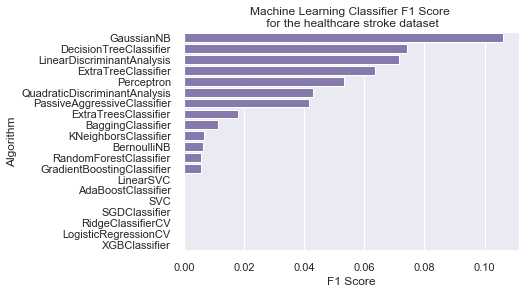

In [67]:
sns.barplot(x='test_f1_score_mean', y = 'ML_classifier_name', data = MLA_compare, color = 'm')
plt.title('Machine Learning Classifier F1 Score \n for the healthcare stroke dataset')
plt.xlabel('F1 Score')
plt.ylabel('Algorithm')

In [68]:
# List of representative models
MLA_classifier_rep = [   
    tree.DecisionTreeClassifier(),
    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),
    naive_bayes.GaussianNB(),
    svm.SVC(probability=True),
    svm.LinearSVC(),
    ensemble.RandomForestClassifier(),
    neighbors.KNeighborsClassifier(),   
    ]

MLA_compare_trim = metric_score_per_ML_clf(X, y, MLA_classifier_rep, cv_split, 'f1')
MLA_compare_trim

ML_classifier_name                                      ML_parameters  \
3              GaussianNB           {'priors': None, 'var_smoothing': 1e-09}   
0  DecisionTreeClassifier  {'class_weight': None, 'criterion': 'gini', 'm...   
7    KNeighborsClassifier  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
6  RandomForestClassifier  {'bootstrap': True, 'class_weight': None, 'cri...   
1    LogisticRegressionCV  {'Cs': 10, 'class_weight': None, 'cv': 'warn',...   
2       RidgeClassifierCV  {'alphas': array([ 0.1,  1. , 10. ]), 'class_w...   
4                     SVC  {'C': 1.0, 'cache_size': 200, 'class_weight': ...   
5               LinearSVC  {'C': 1.0, 'class_weight': None, 'dual': True,...   

  train_score_mean test_score_mean test_score_3*std test_score_min  \
3         0.105381        0.106059        0.0522282      0.0579886   
0                1       0.0758629        0.0289507      0.0578035   
7        0.0377011      0.00657408         0.014417              0   
6         0.855596      0.00646663        0.0205427              0   
1                0               0                0              0   
2                0               0                0              0   
4                0               0                0              0   
5                0               0                0              0   

  mean_running_time  
3         0.0129004  
0         0.0680449  
7          0.235191  
6          0.142292  
1           1.32557  
2         0.0332655  
4           14.0711  
5           0.80801

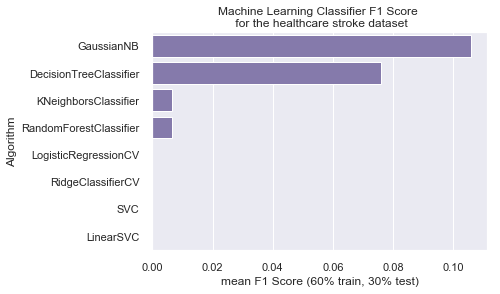

In [69]:
ML_comparison_plot = plt.figure()
sns.barplot(x='test_score_mean', y = 'ML_classifier_name', data = MLA_compare_trim, color = 'm')
plt.title('Machine Learning Classifier F1 Score \n for the healthcare stroke dataset')
plt.xlabel('mean F1 Score (60% train, 30% test)')
plt.ylabel('Algorithm')

ML_comparison_plot.savefig("ML_classifiers_f1_score.pdf", bbox_inches='tight')

From the above table, we can see the classifiers `[GaussianNB, LinearDiscriminantAnalysis, DecisionTreeClassifier]` give the best 3 model performance in this imbalanced classification problem. 

We will pick `[GaussianNB]` as our final ML model for predicting the patient having stroke or not, since it is simple, quick and gives the best performance.

# plotting feature importance (using Decision Tree Classifier)

In [70]:
# Function for plotting (and displaying) the feature importances 
# of a given sklearn estimator 
# --------------------------------------
# Adopted from web: Author, George Fisher

def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (XGBoostError, LightGBMError, ValueError):
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize, legend=False)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

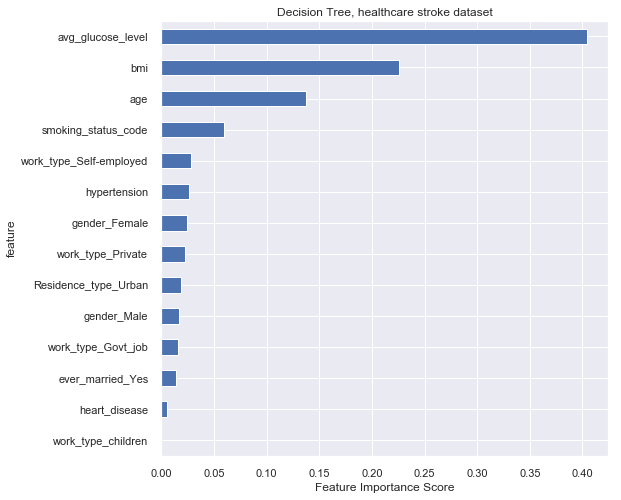

In [71]:
# Plot feature importances for each household (using decision tree classifier)

try:
    _ = plot_feature_importances( tree.DecisionTreeClassifier(), X, y, top_n=X.shape[1],  
                                 title='Decision Tree, healthcare stroke dataset')
except AttributeError as e:
    print(e) 

# V) Model evaluation

To evaluate our ML model performance, we would need to compare the model with some other benchmark models. The benchmark models for comparison here are:

1) random guessing

2) all not strokes

In [73]:
health_stroke_df_ML_final = health_stroke_df_ML.copy()

# 1) random guessing model

for index, row in health_stroke_df_ML_final.iterrows(): 
    if random.random() > .5:        
        health_stroke_df_ML_final.set_value(index, 'random_pred', int(1)) # predict stroke
    else: 
        health_stroke_df_ML_final.set_value(index, 'random_pred', int(0)) # predict no stroke
    

# Compute the corresponding f1 score
print('Random guessing, f1 score: {:.2f}'.format(metrics.f1_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['random_pred'])))
print('Random guessing, roc_auc score: {:.2f}'.format(metrics.roc_auc_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['random_pred'])))
print('Random guessing, accuracy score: {:.2f}'.format(metrics.accuracy_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['random_pred'])))

Random guessing, f1 score: 0.04
Random guessing, roc_auc score: 0.52
Random guessing, accuracy score: 0.50


In [74]:
# 2) all not stroke

health_stroke_df_ML_final['all_not_stroke'] = 0 
print('all not stroke, f1 score: {:.2f}'.format(metrics.f1_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['all_not_stroke'])))
print('all not stroke, roc_auc score: {:.2f}'.format(metrics.roc_auc_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['all_not_stroke'])))
print('all not stroke, accuracy score: {:.2f}'.format(metrics.accuracy_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['all_not_stroke'])))

all not stroke, f1 score: 0.00
all not stroke, roc_auc score: 0.50
all not stroke, accuracy score: 0.98


In [75]:
# Our base ML model, using Gaussian Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=0)
GNB = naive_bayes.GaussianNB()
GNB.fit(X_train, y_train)

health_stroke_df_ML_final['GNB_pred'] = GNB.predict(X)
print('Gaussian Naive Bayes, f1 score: {:.2f}'.format(metrics.f1_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['GNB_pred'])))
print('Gaussian Naive Bayes, roc_auc score: {:.2f}'.format(metrics.roc_auc_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['GNB_pred'])))
print('Gaussian Naive Bayes, accuracy score: {:.2f}'.format(metrics.accuracy_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['GNB_pred'])))

Gaussian Naive Bayes, f1 score: 0.11
Gaussian Naive Bayes, roc_auc score: 0.69
Gaussian Naive Bayes, accuracy score: 0.85


# plotting confusion matrix

In [79]:
# function that plots confusion matrix 
# Adopted from: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

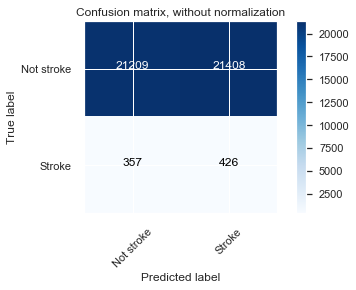

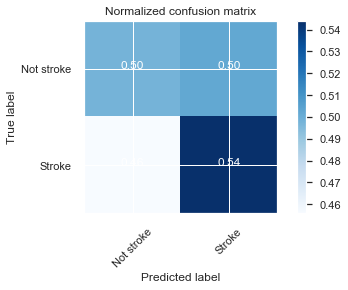

In [80]:
# Compute confusion matrix, benchmark model I: random guessing
cnf_matrix = metrics.confusion_matrix(health_stroke_df_ML_final['stroke'], health_stroke_df_ML_final['random_pred'])
np.set_printoptions(precision=2)

class_names = ['Not stroke', 'Stroke']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

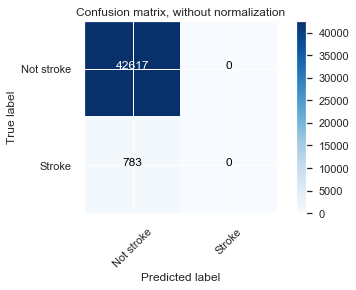

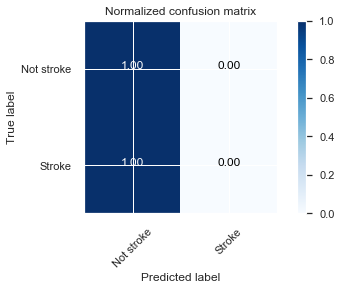

In [81]:
# Compute confusion matrix, benchmark model II: all not stroke
cnf_matrix = metrics.confusion_matrix(health_stroke_df_ML_final['stroke'], 
                                      health_stroke_df_ML_final['all_not_stroke'])
np.set_printoptions(precision=2)

class_names = ['Not stroke', 'Stroke']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

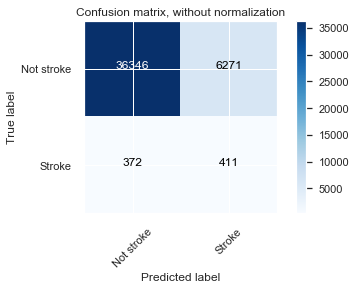

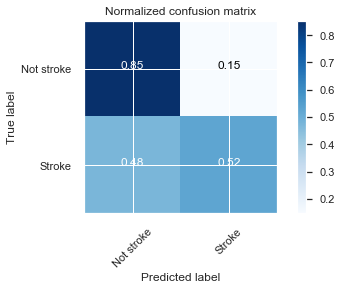

In [82]:
# Compute confusion matrix, Gaussian Naive Bayes
cnf_matrix = metrics.confusion_matrix(health_stroke_df_ML_final['stroke'], health_stroke_df_ML_final['GNB_pred'])
np.set_printoptions(precision=2)

class_names = ['Not stroke', 'Stroke']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

From these results, we can see our base ML Gaussian Naive Bayes model outperforms the benchmark models in this imbalanced classification problem, with roughly a 52% accuracy of predicting `stroke` and 85% for `not stroke`.

# VI) Hyperparameter tuning and feature selection 

To improve our ML model, we would then performing hyperparameter tuning and feature selection. For Gaussian Naive Bayes, there is really only one hyperparameter to be tuned, which is `var_smoothing`.

# Hyperparameter tuning:

In [86]:
# base model
GNB_base = naive_bayes.GaussianNB()
base_results = cross_validate(GNB_base, X, y, scoring='f1', cv = cv_split)
GNB_base.fit(X, y)

print('BEFORE Naive Bayes parameters: ', GNB_base.get_params())
print("BEFORE Naive Bayes Training f1 score mean: {:.2f}". format(base_results['train_score'].mean())) 
print("BEFORE Naive Bayes Test f1 score mean: {:.2f}". format(base_results['test_score'].mean()))
print("BEFORE Naive Bayes Test f1 score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*3))
print('-'*10)


# tune hyper-parameters: 
param_grid = {'var_smoothing': [1e-09, 1e-06, 1e-03, 0.1, 0.5, 1]}

#choose best model with grid_search: 
tune_model = GridSearchCV(naive_bayes.GaussianNB(), param_grid=param_grid, 
                                          scoring = 'f1', cv = cv_split)
tune_model.fit(X, y)


print('AFTER Naive Bayes Parameters: ', tune_model.best_params_)
print("AFTER Naive Bayes Training f1 score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_])) 
print("AFTER Naive Bayes Test f1 score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]))
print("AFTER Naive Bayes Test f1 score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*3))
print('-'*10)

BEFORE Naive Bayes parameters:  {'priors': None, 'var_smoothing': 1e-09}
BEFORE Naive Bayes Training f1 score mean: 0.11
BEFORE Naive Bayes Test f1 score mean: 0.11
BEFORE Naive Bayes Test f1 score 3*std: +/- 0.05
----------
AFTER Naive Bayes Parameters:  {'var_smoothing': 0.001}
AFTER Naive Bayes Training f1 score mean: 0.11
AFTER Naive Bayes Test f1 score mean: 0.11
AFTER Naive Bayes Test f1 score 3*std: +/- 0.02
----------


# feature selection
testing the model performance with different feature variable combinations

In [87]:
# base model
print('BEFORE GNB RFE Training Shape Old: ', X.shape) 
print('BEFORE GNB RFE Training Columns Old: ', X.columns.values)

print("BEFORE GNB RFE Training f1 score mean: {:.2f}". format(base_results['train_score'].mean())) 
print("BEFORE GNB RFE Test f1 score mean: {:.2f}". format(base_results['test_score'].mean()))
print("BEFORE GNB RFE Test f1 score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*3))
print('-'*10)

# selecting specific combinations of feature variable to be used
sel_feature = ['avg_glucose_level', 'bmi', 'age', 'smoking_status_code', 'hypertension', 'heart_disease',
               'ever_married_Yes']
sfe_results = cross_validate(GNB_base, X[sel_feature], y, scoring='f1', cv = cv_split)

print('AFTER GNB RFE Training Shape New: ', X[sel_feature].shape) 
print('AFTER GNB RFE Training Columns New: ', sel_feature)

print("AFTER GNB RFE Training f1 score mean: {:.2f}". format(sfe_results['train_score'].mean())) 
print("AFTER GNB RFE Test f1 score mean: {:.2f}". format(sfe_results['test_score'].mean()))
print("AFTER GNB RFE Test f1 score 3*std: +/- {:.2f}". format(sfe_results['test_score'].std()*3))
print('-'*10)

# tune hyper-parameters: 
param_grid = {'var_smoothing': [1e-09, 1e-06, 1e-03, 0.1, 0.5, 1]}

# tune rfe model
sfe_tune_model = GridSearchCV(naive_bayes.GaussianNB(var_smoothing=0.1), param_grid=param_grid, 
                              scoring = 'f1', cv = cv_split)
sfe_tune_model.fit(X[sel_feature], y)


print('AFTER GNB RFE Tuned Parameters: ', sfe_tune_model.best_params_)
print("AFTER GNB RFE Tuned Training f1 score mean: {:.2f}". format(sfe_tune_model.cv_results_['mean_train_score'][sfe_tune_model.best_index_])) 
print("AFTER GNB RFE Tuned Test f1 score mean: {:.2f}". format(sfe_tune_model.cv_results_['mean_test_score'][sfe_tune_model.best_index_]))
print("AFTER GNB RFE Tuned Test f1 score 3*std: +/- {:.2f}". format(sfe_tune_model.cv_results_['std_test_score'][sfe_tune_model.best_index_]*3))
print('-'*10)

BEFORE GNB RFE Training Shape Old:  (43400, 14)
BEFORE GNB RFE Training Columns Old:  ['age' 'hypertension' 'heart_disease' 'avg_glucose_level' 'bmi'
 'gender_Female' 'gender_Male' 'ever_married_Yes' 'work_type_Govt_job'
 'work_type_Private' 'work_type_Self-employed' 'work_type_children'
 'Residence_type_Urban' 'smoking_status_code']
BEFORE GNB RFE Training f1 score mean: 0.11
BEFORE GNB RFE Test f1 score mean: 0.11
BEFORE GNB RFE Test f1 score 3*std: +/- 0.05
----------
AFTER GNB RFE Training Shape New:  (43400, 7)
AFTER GNB RFE Training Columns New:  ['avg_glucose_level', 'bmi', 'age', 'smoking_status_code', 'hypertension', 'heart_disease', 'ever_married_Yes']
AFTER GNB RFE Training f1 score mean: 0.13
AFTER GNB RFE Test f1 score mean: 0.13
AFTER GNB RFE Test f1 score 3*std: +/- 0.03
----------
AFTER GNB RFE Tuned Parameters:  {'var_smoothing': 0.001}
AFTER GNB RFE Tuned Training f1 score mean: 0.13
AFTER GNB RFE Tuned Test f1 score mean: 0.13
AFTER GNB RFE Tuned Test f1 score 3*std:

Using only s subset of the whole available features, i.e. `['avg_glucose_level', 'bmi', 'age', 'smoking_status_code', 'hypertension', 'heart_disease', 'ever_married_Yes']`, we can get an improvement of `0.02` in the f1 score for our Gaussian Naive Bayes model.

# VII) Discussion

Question: what is the appropriate metric here? 

While we are using the `f1 score` here for analysis, it should be stressed that this is not necessarily the best metric in certain scenarios. To be precise, what metric to use should depend on the ultimate goal of the predictive model.

For instance, if the goal is to have a predictive model for both binary classes as accurate as possible, `f1 score` or `roc_auc` would then be a good choice. However, if we only want to predict patients with stroke as accurate as possible, `recall` would be more appropriate.

In [88]:
# Checking how the ML classifers performance changes if we use roc_auc as metrics instead

cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

# Label the final preprocessed feature variables as X and target as Y
X = health_stroke_df_ML[feature_col]
y = health_stroke_df_ML[target_var]

roc_auc_ML_estimate_df = metric_score_per_ML_clf(X, y, MLA_classifier, cv_split, 'roc_auc')
roc_auc_ML_estimate_df 

ML_classifier_name  \
19                  XGBClassifier   
14     GradientBoostingClassifier   
11             AdaBoostClassifier   
10                      LinearSVC   
4               RidgeClassifierCV   
17     LinearDiscriminantAnalysis   
8                      GaussianNB   
2            LogisticRegressionCV   
3     PassiveAggressiveClassifier   
5                   SGDClassifier   
7                     BernoulliNB   
6                      Perceptron   
18  QuadraticDiscriminantAnalysis   
12              BaggingClassifier   
15         RandomForestClassifier   
9                             SVC   
13           ExtraTreesClassifier   
16           KNeighborsClassifier   
0          DecisionTreeClassifier   
1             ExtraTreeClassifier   

                                        ML_parameters train_score_mean  \
19  {'base_score': 0.5, 'booster': 'gbtree', 'cols...         0.886844   
14  {'criterion': 'friedman_mse', 'init': None, 'l...         0.901469   
11  {'algorithm': 'SAMME.R', 'base_estimator': Non...         0.874101   
10  {'C': 1.0, 'class_weight': None, 'dual': True,...         0.848527   
4   {'alphas': array([ 0.1,  1. , 10. ]), 'class_w...         0.845788   
17  {'n_components': None, 'priors': None, 'shrink...         0.845654   
8            {'priors': None, 'var_smoothing': 1e-09}         0.822429   
2   {'Cs': 10, 'class_weight': None, 'cv': 'warn',...         0.765222   
3   {'C': 1.0, 'average': False, 'class_weight': N...          0.77306   
5   {'alpha': 0.0001, 'average': False, 'class_wei...         0.758766   
7   {'alpha': 1.0, 'binarize': 0.0, 'class_prior':...         0.742313   
6   {'alpha': 0.0001, 'class_weight': None, 'early...         0.716021   
18  {'priors': None, 'reg_param': 0.0, 'store_cova...         0.710453   
12  {'base_estimator': None, 'bootstrap': True, 'b...         0.999916   
15  {'bootstrap': True, 'class_weight': None, 'cri...         0.999929   
9   {'C': 1.0, 'cache_size': 200, 'class_weight': ...         0.701356   
13  {'bootstrap': False, 'class_weight': None, 'cr...                1   
16  {'algorithm': 'auto', 'leaf_size': 30, 'metric...         0.971326   
0   {'class_weight': None, 'criterion': 'gini', 'm...                1   
1   {'class_weight': None, 'criterion': 'gini', 'm...                1   

   test_score_mean test_score_3*std test_score_min mean_running_time  
19        0.856785        0.0207904       0.845836          0.918968  
14        0.853573        0.0237536       0.840267           1.17512  
11         0.85233        0.0169928        0.84121            0.5252  
10        0.848246        0.0279956       0.831662          0.545515  
4         0.846087        0.0297012       0.829676         0.0333064  
17        0.845889        0.0299471       0.829389         0.0542566  
8         0.825157        0.0176778       0.810828         0.0147756  
2         0.775643        0.0460235       0.750081           1.36706  
3         0.770411         0.144928       0.668781         0.0245147  
5         0.750919         0.128821       0.679853         0.0238042  
7           0.7508        0.0258337       0.733125         0.0132399  
6         0.714039         0.194607       0.596695         0.0222568  
18        0.705459         0.200852       0.615103         0.0196458  
12        0.671093        0.0408163       0.645591          0.389143  
15        0.637354        0.0485037       0.614272          0.132136  
9         0.621004        0.0973448       0.568623           13.9029  
13        0.605834        0.0493735       0.580088         0.0928273  
16        0.581573         0.025134       0.568829          0.208757  
0         0.529071        0.0174527         0.5205         0.0690914  
1         0.524826        0.0158872       0.515249         0.0152554

In [89]:
# Best ML model for recall

recall_ML_estimate_df = metric_score_per_ML_clf(X, y, MLA_classifier, cv_split, 'recall')
recall_ML_estimate_df 

ML_classifier_name  \
18  QuadraticDiscriminantAnalysis   
8                      GaussianNB   
6                      Perceptron   
0          DecisionTreeClassifier   
1             ExtraTreeClassifier   
17     LinearDiscriminantAnalysis   
3     PassiveAggressiveClassifier   
13           ExtraTreesClassifier   
12              BaggingClassifier   
7                     BernoulliNB   
16           KNeighborsClassifier   
15         RandomForestClassifier   
14     GradientBoostingClassifier   
10                      LinearSVC   
11             AdaBoostClassifier   
9                             SVC   
5                   SGDClassifier   
4               RidgeClassifierCV   
2            LogisticRegressionCV   
19                  XGBClassifier   

                                        ML_parameters train_score_mean  \
18  {'priors': None, 'reg_param': 0.0, 'store_cova...         0.816782   
8            {'priors': None, 'var_smoothing': 1e-09}         0.550779   
6   {'alpha': 0.0001, 'class_weight': None, 'early...         0.103652   
0   {'class_weight': None, 'criterion': 'gini', 'm...                1   
1   {'class_weight': None, 'criterion': 'gini', 'm...                1   
17  {'n_components': None, 'priors': None, 'shrink...        0.0486994   
3   {'C': 1.0, 'average': False, 'class_weight': N...        0.0431221   
13  {'bootstrap': False, 'class_weight': None, 'cr...                1   
12  {'base_estimator': None, 'bootstrap': True, 'b...         0.769248   
7   {'alpha': 1.0, 'binarize': 0.0, 'class_prior':...       0.00398621   
16  {'algorithm': 'auto', 'leaf_size': 30, 'metric...        0.0196137   
15  {'bootstrap': True, 'class_weight': None, 'cri...          0.76985   
14  {'criterion': 'friedman_mse', 'init': None, 'l...        0.0364661   
10  {'C': 1.0, 'class_weight': None, 'dual': True,...                0   
11  {'algorithm': 'SAMME.R', 'base_estimator': Non...        0.0010539   
9   {'C': 1.0, 'cache_size': 200, 'class_weight': ...                0   
5   {'alpha': 0.0001, 'average': False, 'class_wei...                0   
4   {'alphas': array([ 0.1,  1. , 10. ]), 'class_w...                0   
2   {'Cs': 10, 'class_weight': None, 'cv': 'warn',...                0   
19  {'base_score': 0.5, 'booster': 'gbtree', 'cols...                0   

   test_score_mean test_score_3*std test_score_min mean_running_time  
18        0.818657         0.918098       0.150407         0.0160992  
8         0.555037         0.422061        0.46383         0.0112767  
6         0.113207         0.558128              0         0.0216144  
0        0.0830917        0.0444623      0.0576132         0.0635076  
1        0.0512203        0.0368719      0.0323887         0.0140198  
17       0.0491022         0.043285      0.0288066         0.0523551  
3        0.0486551         0.374514              0         0.0184274  
13      0.00651606        0.0184602              0         0.0964215  
12      0.00512843        0.0125981              0          0.401344  
7       0.00347982        0.0130236              0         0.0114936  
16      0.00339765       0.00748011              0          0.201254  
15      0.00308071         0.013536              0          0.134683  
14      0.00255258       0.00626738              0           1.20376  
10               0                0              0          0.542634  
11               0                0              0          0.534283  
9                0                0              0           12.0974  
5                0                0              0         0.0184183  
4                0                0              0          0.026767  
2                0                0              0           1.02227  
19               0                0              0           0.93374

For the above, we can see that `Gaussian Naive Bayes` would still be a very good model even when using `recall` as the metric.

# VIII) Conclusion
# our final Naive Bayes model

In [90]:
health_stroke_df_ML_final = health_stroke_df_ML.copy()

# Our final ML model, using Gaussian Naive Bayes
X_train, X_test, y_train, y_test = train_test_split(X[sel_feature], y, train_size=.6, random_state=42)
GNB_final = naive_bayes.GaussianNB(var_smoothing=0.001)
GNB_final.fit(X_train, y_train)

health_stroke_df_ML_final['GNB_pred'] = GNB_final.predict(X[sel_feature])
print('Gaussian Naive Bayes, f1 score: {:.2f}'.format(metrics.f1_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['GNB_pred'])))
print('Gaussian Naive Bayes, roc_auc score: {:.2f}'.format(metrics.roc_auc_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['GNB_pred'])))
print('Gaussian Naive Bayes, accuracy score: {:.2f}'.format(metrics.accuracy_score(health_stroke_df_ML_final['stroke'], 
                                                                  health_stroke_df_ML_final['GNB_pred'])))

Gaussian Naive Bayes, f1 score: 0.13
Gaussian Naive Bayes, roc_auc score: 0.63
Gaussian Naive Bayes, accuracy score: 0.92


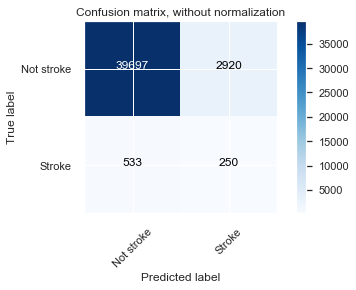

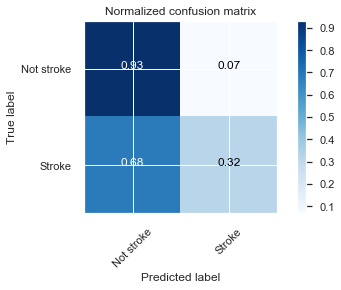

In [91]:
# Compute confusion matrix, Gaussian Naive Bayes (final)
cnf_matrix = metrics.confusion_matrix(health_stroke_df_ML_final['stroke'], health_stroke_df_ML_final['GNB_pred'])
np.set_printoptions(precision=2)

class_names = ['Not stroke', 'Stroke']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

# Aside: comparing results with or without imputation

In [93]:
MLA_top3_classifier = [   
    tree.DecisionTreeClassifier(),
    naive_bayes.GaussianNB(var_smoothing=0.001),
    discriminant_analysis.LinearDiscriminantAnalysis()]

# Label the final preprocessed feature variables as X and target as Y
X = health_stroke_df_ML[feature_col]
y = health_stroke_df_ML[target_var]

cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 

# The imputed model results
MLA_top3_compare = metric_score_per_ML_clf(X, y, MLA_top3_classifier, cv_split, 'f1')
MLA_top3_compare

ML_classifier_name  \
1                  GaussianNB   
2  LinearDiscriminantAnalysis   
0      DecisionTreeClassifier   

                                       ML_parameters train_score_mean  \
1           {'priors': None, 'var_smoothing': 0.001}         0.110732   
2  {'n_components': None, 'priors': None, 'shrink...          0.07079   
0  {'class_weight': None, 'criterion': 'gini', 'm...                1   

  test_score_mean test_score_3*std test_score_min mean_running_time  
1        0.110998        0.0221051       0.101646         0.0125158  
2       0.0715845         0.048442      0.0496454          0.051693  
0       0.0696963        0.0300063      0.0539499         0.0625463

In [94]:
# Label encoding for the without imputation df (droping missing values)

nom_col = ['gender', 'ever_married', 'work_type', 'Residence_type']
ord_col = ['smoking_status']

health_stroke_without_NAN_df = pd.get_dummies(health_stroke_without_NAN_df, columns = nom_col)

ord_var_code = 'smoking_status_code'
smoke_mapper = {'never smoked': 0, 'formerly smoked': 1,'smokes':2}
health_stroke_without_NAN_df[ord_var_code] = health_stroke_without_NAN_df['smoking_status'].map(smoke_mapper)

min_max_scaler = MinMaxScaler()
health_stroke_without_NAN_df[numeric_col] = min_max_scaler.fit_transform(health_stroke_without_NAN_df[numeric_col])

health_stroke_without_NAN_df = health_stroke_without_NAN_df.drop(columns=['id', 'gender_Other', 'ever_married_No', 
                                                                          'Residence_type_Rural',
                                                                          'work_type_Never_worked', 
                                                                          'smoking_status'])

In [96]:
# Inspect basic info after label encoding
health_stroke_without_NAN_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29072 entries, 1 to 43399
Data columns (total 15 columns):
age                        29072 non-null float64
hypertension               29072 non-null int64
heart_disease              29072 non-null int64
avg_glucose_level          29072 non-null float64
bmi                        29072 non-null float64
stroke                     29072 non-null int64
gender_Female              29072 non-null uint8
gender_Male                29072 non-null uint8
ever_married_Yes           29072 non-null uint8
work_type_Govt_job         29072 non-null uint8
work_type_Private          29072 non-null uint8
work_type_Self-employed    29072 non-null uint8
work_type_children         29072 non-null uint8
Residence_type_Urban       29072 non-null uint8
smoking_status_code        29072 non-null int64
dtypes: float64(3), int64(4), uint8(8)
memory usage: 2.0 MB


In [98]:
# Label the final preprocessed feature variables as X and target as Y (no imputation, dropna)
X_no_imp = health_stroke_without_NAN_df[feature_col]
y_no_imp = health_stroke_without_NAN_df[target_var]

# The non-imputed model results
MLA_top3_compare_no_imp = metric_score_per_ML_clf(X_no_imp, y_no_imp, MLA_top3_classifier, cv_split, 'f1')
MLA_top3_compare_no_imp

ML_classifier_name  \
1                  GaussianNB   
0      DecisionTreeClassifier   
2  LinearDiscriminantAnalysis   

                                       ML_parameters train_score_mean  \
1           {'priors': None, 'var_smoothing': 0.001}         0.116037   
0  {'class_weight': None, 'criterion': 'gini', 'm...                1   
2  {'n_components': None, 'priors': None, 'shrink...        0.0511105   

  test_score_mean test_score_3*std test_score_min mean_running_time  
1        0.114886        0.0336327      0.0946271        0.00762174  
0       0.0605006        0.0485604      0.0376344          0.045312  
2       0.0415022        0.0605173      0.0224719         0.0342992

In [100]:
# Merging the with/without imputation results

f1_score_test_col = ["ML_classifier_name", "test_score_mean", "test_score_3*std"]

df_no_imp = MLA_top3_compare_no_imp[f1_score_test_col]
df_no_imp.rename(columns={'test_score_mean': 'f1_score_no_imp', 
                                        'test_score_3*std':  'f1_score_no_imp_3*std'}, inplace=True)
df_imp = MLA_top3_compare[f1_score_test_col]
df_imp.rename(columns={'test_score_mean': 'f1_score_imp', 
                                 'test_score_3*std':  'f1_score_imp_3*std'}, inplace=True)

result = pd.merge(df_no_imp, df_imp, on='ML_classifier_name')

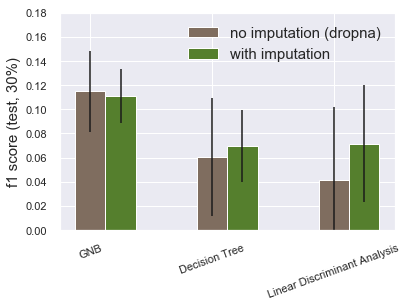

In [101]:
# set width of bar
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(result.ML_classifier_name))
r2 = [x + barWidth for x in r1]
 
# Plot the f1 score results with/without imputation
imp_impact_plot = plt.figure()
plt.bar(r1, result['f1_score_no_imp'], color='#7f6d5f', width=barWidth, yerr=result['f1_score_no_imp_3*std'],
        edgecolor='white', label='no imputation (dropna)')
plt.bar(r2, result['f1_score_imp'], color='#557f2d', width=barWidth, yerr=result['f1_score_imp_3*std'],
        edgecolor='white', label='with imputation')
 
plt.ylim(0,0.18)
plt.ylabel('f1 score (test, 30%)',fontsize=15)
plt.xticks(r1, ('GNB', 'Decision Tree', 'Linear Discriminant Analysis'), rotation=20)
plt.legend(fontsize=15)
plt.show()

imp_impact_plot.savefig("imp_impact_on_f1_score.pdf", bbox_inches='tight')

For the above, we can see that `Gaussian Naive Bayes` would be very much unaffected by the imputation preprocessing step, whereas for other ML classifiers like `[Decision Tree, Linear Discriminant Analysis]`, the model performs (significantly) poorer without imputation.

# Aside: comparing results with/without standardise numeric variables

In [102]:
# Label the final preprocessed feature variables as X and target as Y
X_non_stand = health_stroke_df_ML_non_stand[feature_col]
y_non_stand = health_stroke_df_ML_non_stand[target_var]

# The non-imputed model results
MLA_top3_compare_no_stand = metric_score_per_ML_clf(X_non_stand, y_non_stand, MLA_top3_classifier, cv_split, 'f1')
MLA_top3_compare_no_stand

ML_classifier_name  \
1                  GaussianNB   
0      DecisionTreeClassifier   
2  LinearDiscriminantAnalysis   

                                       ML_parameters train_score_mean  \
1           {'priors': None, 'var_smoothing': 0.001}        0.0768703   
0  {'class_weight': None, 'criterion': 'gini', 'm...                1   
2  {'n_components': None, 'priors': None, 'shrink...          0.07079   

  test_score_mean test_score_3*std test_score_min mean_running_time  
1       0.0764106        0.0396949      0.0472441         0.0148349  
0       0.0729836        0.0183529      0.0620155         0.0635132  
2       0.0715845         0.048442      0.0496454         0.0600056

In [103]:
# Merging the with/without standardise results

f1_score_test_col = ["ML_classifier_name", "test_score_mean", "test_score_3*std"]

df_no_stand = MLA_top3_compare_no_stand[f1_score_test_col]
df_no_stand.rename(columns={'test_score_mean': 'f1_score_no_stand', 
                                        'test_score_3*std':  'f1_score_no_stand_3*std'}, inplace=True)
df_imp.rename(columns={'f1_score_imp': 'f1_score_stand', 
                       'f1_score_imp_3*std': 'f1_score_stand_3*std'}, inplace=True)

result_stand = pd.merge(df_no_stand, df_imp, on='ML_classifier_name')

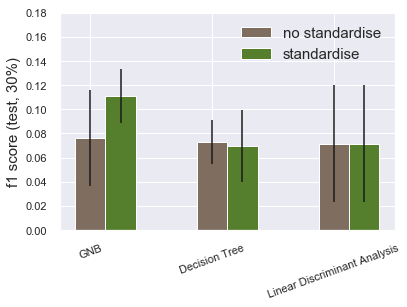

In [104]:
# Plot the f1 score results with/without imputation
stand_impact_plot = plt.figure()
plt.bar(r1, result_stand['f1_score_no_stand'], color='#7f6d5f', width=barWidth, 
        yerr=result_stand['f1_score_no_stand_3*std'], edgecolor='white', label='no standardise')
plt.bar(r2, result_stand['f1_score_stand'], color='#557f2d', width=barWidth, 
        yerr=result_stand['f1_score_stand_3*std'], edgecolor='white', label='standardise')
 
plt.ylim(0,0.18)
plt.ylabel('f1 score (test, 30%)',fontsize=15)
plt.xticks(r1, ('GNB', 'Decision Tree', 'Linear Discriminant Analysis'), rotation=20)
plt.legend(fontsize=15)
plt.show()

stand_impact_plot.savefig("stand_impact_on_f1_score.pdf", bbox_inches='tight')

For the above, we can see that `[Decision Tree, Linear Discriminant Analysis]` would be very much unaffected by the imputation preprocessing step, whereas for other ML classifiers like `Gaussian Naive Bayes`, the model performs significantly poorer without imputation.

The results confirming the fact that standardise/scaling is not a preprocessing step required for `tree class` ML models.

# Aside: plotting train/test f1 score for various splitting ratio

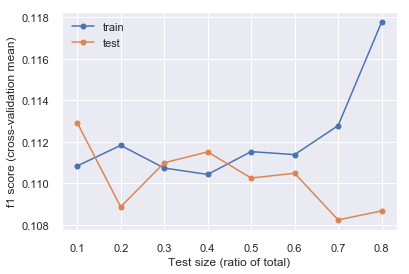

In [108]:
GNB_classifier = [naive_bayes.GaussianNB(var_smoothing=0.001)]

# Label the final preprocessed feature variables as X and target as Y
X = health_stroke_df_ML[feature_col]
y = health_stroke_df_ML[target_var]

train_score = []
test_score = []

for test in np.linspace(0.1,0.8,num=8):
    cv_split = ShuffleSplit(n_splits = 10, test_size = test, train_size = 0.9-test, random_state = 0 ) 
    
    # The imputed model results
    GNB_compare_test_size = metric_score_per_ML_clf(X, y, GNB_classifier, cv_split, 'f1')
    train_score.append(GNB_compare_test_size.train_score_mean)
    test_score.append(GNB_compare_test_size.test_score_mean)
    
overfit_check_plot = plt.figure()    
plt.plot(np.linspace(0.1,0.8,num=8), train_score, '-o')
plt.plot(np.linspace(0.1,0.8,num=8), test_score, '-o')
plt.xlabel('Test size (ratio of total)')
plt.ylabel('f1 score (cross-validation mean)')
plt.legend(['train', 'test'])

overfit_check_plot.savefig("test_size_impact_on_f1_score.pdf", bbox_inches='tight')

For the above, we can see the train and test (validation) scores agree well, especially within the test size range `[0.3-0.4]`. This suggests the model is safe from overfitting.